CODE 1: SEQUENCE TO PREDICTION TRANSFORMER WITH NSAI (WITH CLOSE ALONE AS INPUT FEATURE)

Enter future date (DD-MM-YYYY): 17-04-2025


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


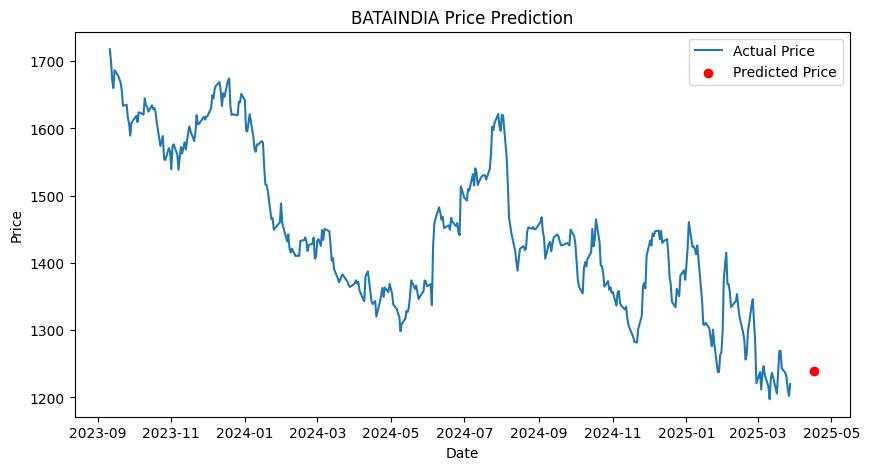

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


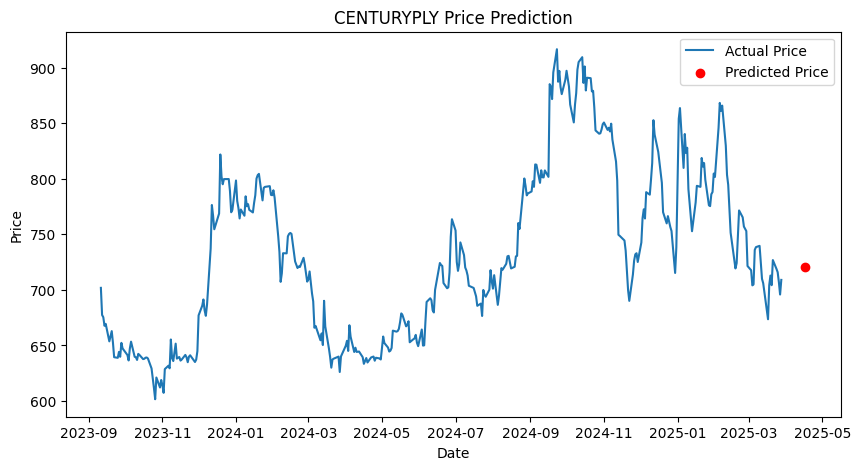

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


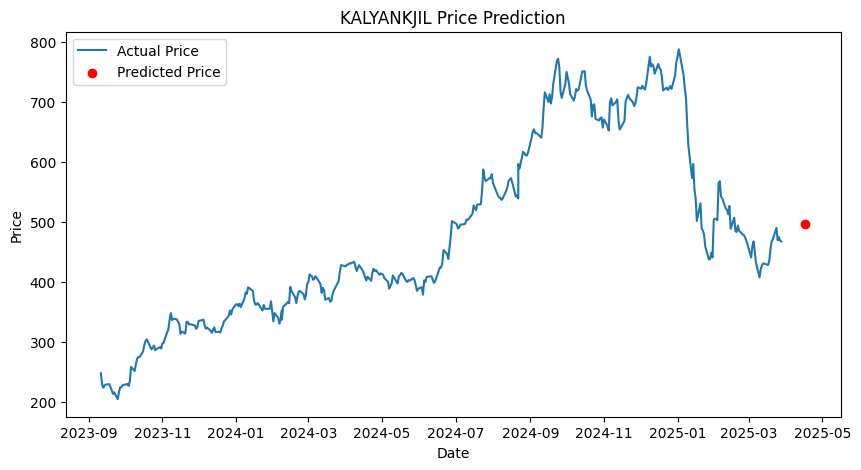

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


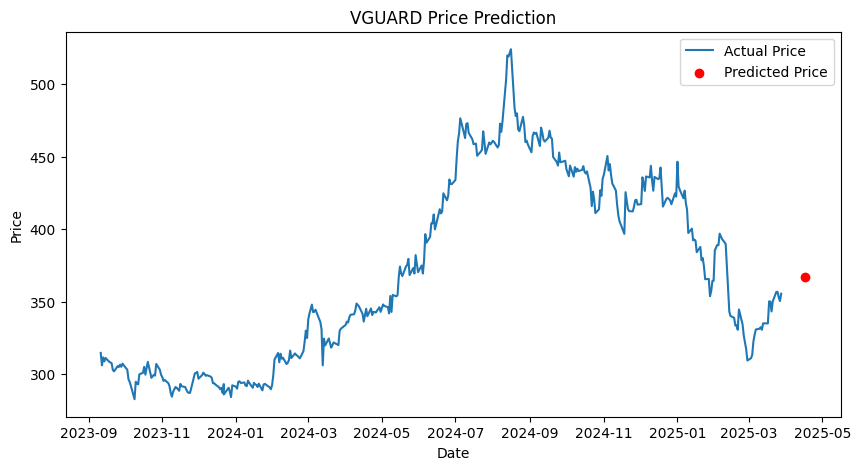

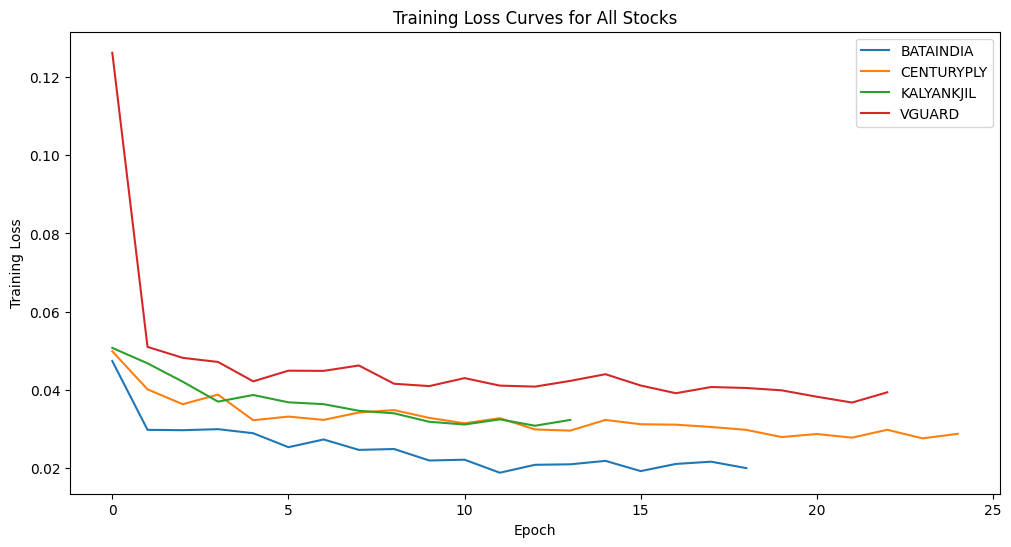

        Stock  Predicted Close       MSE  R-squared      MSLE       MSPE  \
0   BATAINDIA      1239.143292  0.406569   0.593431  0.000715   7.404995   
1  CENTURYPLY       720.344724  0.147212   0.852788  0.000651   6.779833   
2  KALYANKJIL       495.787048  0.889587   0.110413  0.004866  53.027404   
3      VGUARD       367.362963  0.393127   0.606873  0.001736  18.577039   

       Accuracy Reliability   Trend Action      Risk Variance  
0  Low Accuracy  Unreliable  Stable   Hold  Low Risk   Stable  
1  Low Accuracy    Reliable  Stable   Hold  Low Risk   Stable  
2  Low Accuracy  Unreliable  Upward    Buy  Low Risk   Stable  
3  Low Accuracy  Unreliable  Stable   Hold  Low Risk   Stable  


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import datetime

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.2):
        super(TransformerModel, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.norm = nn.LayerNorm(d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.input_proj(src)
        src = self.norm(src)
        output = self.transformer_encoder(src)
        output = self.fc_out(output[:, -1, :])
        return output

# Custom Dataset
class StockDataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        return (self.data[idx:idx+self.sequence_length], self.data[idx+self.sequence_length])

# Huber Loss
class HuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super().__init__()
        self.delta = delta

    def forward(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = torch.abs(error) <= self.delta
        small_error_loss = 0.5 * error ** 2
        large_error_loss = self.delta * (torch.abs(error) - 0.5 * self.delta)
        return torch.mean(torch.where(is_small_error, small_error_loss, large_error_loss))

# Load and preprocess data
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()  # Remove leading/trailing spaces from column names
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
    df['close'] = df['close'].astype(str).str.replace(',', '').astype(float)
    df.sort_values('Date', inplace=True)
    return df[['Date', 'close']]

# MSLE metric
def mean_squared_log_error(y_true, y_pred):
    return np.mean((np.log1p(y_true) - np.log1p(y_pred))**2)

# MSPE metric
def mean_squared_percentage_error(y_true, y_pred):
    epsilon = 1e-10
    return np.mean(((y_true - y_pred) / (y_true + epsilon))**2) * 100

# Train model
def train_model(train_loader, input_dim, epochs=25, lr=0.00002, patience=10):
    model = TransformerModel(input_dim=input_dim)
    criterion = HuberLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

    best_val_loss = float('inf')
    best_model = None
    patience_counter = 0

    epoch_losses = []  # Store training loss per epoch

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        count = 0
        for seq, target in train_loader:
            optimizer.zero_grad()
            output = model(seq.float())
            loss = criterion(output, target.float().unsqueeze(1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            count += 1

        avg_train_loss = total_loss / count
        epoch_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for seq, target in train_loader:
                output = model(seq.float())
                loss = criterion(output, target.float().unsqueeze(1))
                val_loss += loss.item()
        val_loss /= len(train_loader)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model.load_state_dict(best_model)
    return model, epoch_losses

# Predict using last sequence
def predict(model, data, sequence_length=30):
    last_seq = torch.tensor(data[-sequence_length:]).float().unsqueeze(0)
    model.eval()
    with torch.no_grad():
        pred = model(last_seq).item()
    return pred

# NSAI rules
def generate_rules(actual, predicted, mse, r2, mape):
    rules = {
        "Accuracy": "High" if mse < 0.02 else "Low Accuracy",
        "Reliability": "Reliable" if r2 > 0.8 else "Unreliable",
        "Trend": "Upward" if predicted > actual * 1.05 else "Downward" if predicted < actual * 0.95 else "Stable",
        "Action": "Buy" if predicted > actual * 1.05 else "Sell" if predicted < actual * 0.95 else "Hold",
        "Risk": "Low Risk" if mape < 10 else "High Risk",
        "Variance": "Stable" if abs((predicted - actual) / actual) <= 0.1 else "Volatile"
    }
    return rules

# 80-20 Train-Test Split
def train_test_split(data, sequence_length=30, train_ratio=0.8):
    train_size = int(len(data) * train_ratio)
    train_data = data[:train_size]
    test_data = data[train_size:]

    train_dataset = StockDataset(train_data, sequence_length)
    test_dataset = StockDataset(test_data, sequence_length)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

    return train_loader, test_loader

# Main Execution
if __name__ == "__main__":
    csv_files = ['BATAINDIA.csv', 'CENTURYPLY.csv', 'KALYANKJIL.csv', 'VGUARD.csv']  # Add more if needed
    future_date = input("Enter future date (DD-MM-YYYY): ")
    future_date = datetime.datetime.strptime(future_date, "%d-%m-%Y")
    results = []

    all_training_losses = {}  # For storing loss curves of all stocks

    for file in csv_files:
        stock_name = os.path.basename(file).replace(".csv", "")
        df = load_and_preprocess_data(file)
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df[['close']])
        scaled_data = scaled_data.reshape(-1, 1)

        train_loader, test_loader = train_test_split(scaled_data, sequence_length=30)
        model, epoch_losses = train_model(train_loader, input_dim=1)
        all_training_losses[stock_name] = epoch_losses

        preds = []
        actuals = []
        model.eval()
        with torch.no_grad():
            for seq, target in test_loader:
                output = model(seq.float())
                preds.extend(output.numpy().flatten())
                actuals.extend(target.numpy().flatten())

        preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
        actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

        predicted_price = predict(model, scaled_data)
        predicted_price = scaler.inverse_transform([[predicted_price]])[0][0]

        actual_price = df['close'].iloc[-1]
        r2 = r2_score(actuals, preds)
        mse = 1 - r2
        mape = mean_absolute_percentage_error(actuals, preds) * 100

        msle = mean_squared_log_error(actuals, preds)
        mspe = mean_squared_percentage_error(actuals, preds)*100

        rules = generate_rules(actual_price, predicted_price, mse, r2, mape)
        results.append([
            stock_name, predicted_price, mse, r2, msle, mspe,
            rules["Accuracy"], rules["Reliability"], rules["Trend"],
            rules["Action"], rules["Risk"], rules["Variance"]
        ])

        # Plot actual vs predicted with future date
        plt.figure(figsize=(10, 5))
        plt.plot(df['Date'], df['close'], label='Actual Price')
        plt.scatter([future_date], [predicted_price], color='red', label='Predicted Price')
        plt.title(f"{stock_name} Price Prediction")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.show()

    # Plot training loss curves for all stocks
    plt.figure(figsize=(12, 6))
    for stock, losses in all_training_losses.items():
        plt.plot(losses, label=stock)
    plt.title("Training Loss Curves for All Stocks")
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.legend()
    plt.show()

    # Output table with MSLE and MSPE added, Accuracy % removed
    results_df = pd.DataFrame(results, columns=[
        'Stock', 'Predicted Close', 'MSE', 'R-squared', 'MSLE', 'MSPE',
        'Accuracy', 'Reliability', 'Trend', 'Action', 'Risk', 'Variance'
    ])
    print(results_df)


CODE 2: SEQUENCE TO PREDICTION TRANSFORMER WITH NSAI (WITH OPEN, HIGH, LOW, CLOSE AS INPUT FEATURE)

Enter future date (DD-MM-YYYY): 17-04-2025


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


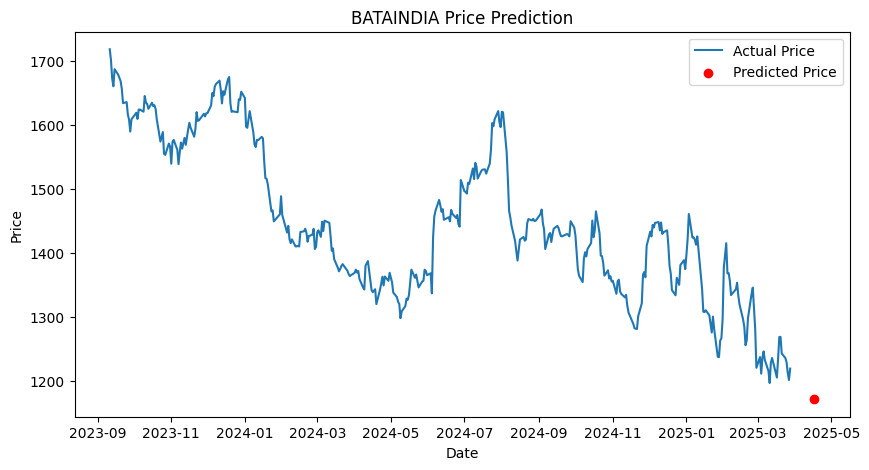

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


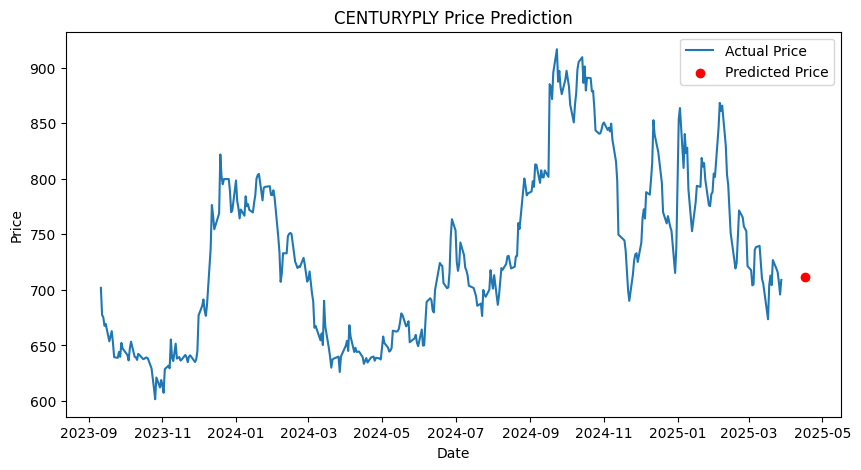

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


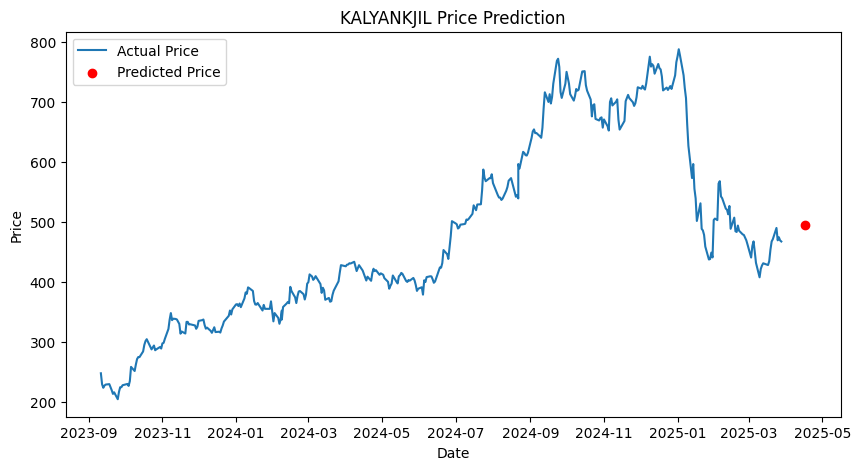

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


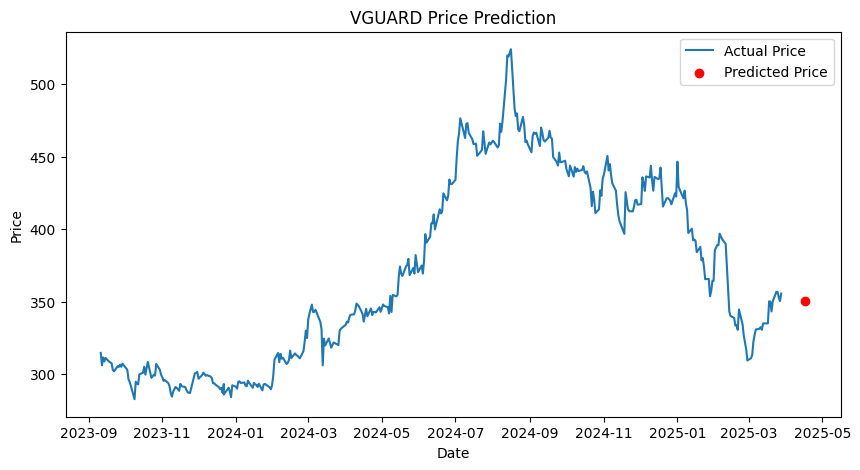

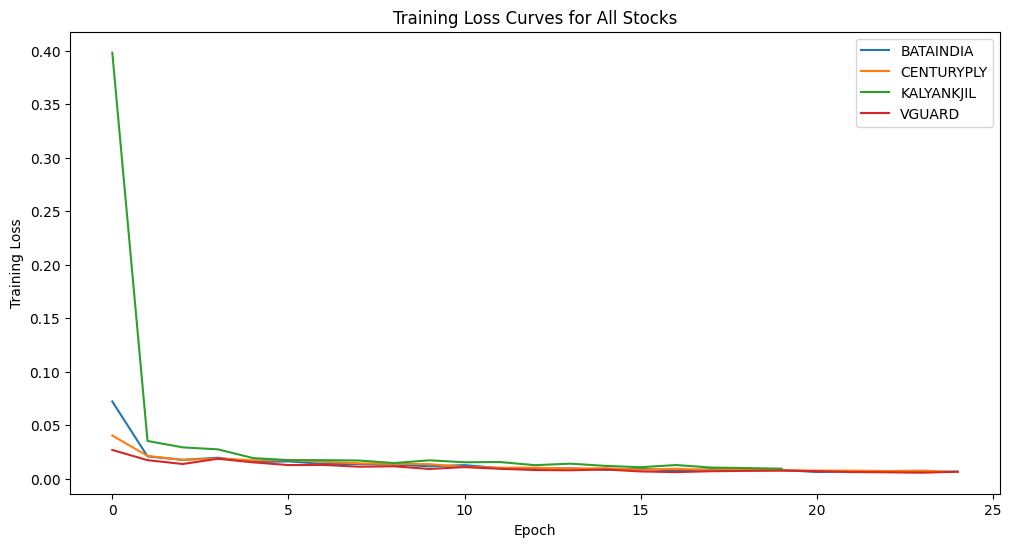

        Stock  Predicted Close       MSE  R-squared      MSLE       MSPE  \
0   BATAINDIA      1172.114657  0.547036   0.452964  0.001022   9.790771   
1  CENTURYPLY       711.506090  0.246428   0.753572  0.001067  11.183202   
2  KALYANKJIL       495.318358  1.026740  -0.026740  0.005282  58.320506   
3      VGUARD       350.714283  0.149518   0.850482  0.000671   6.689204   

       Accuracy Reliability   Trend Action      Risk Variance  
0  Low Accuracy  Unreliable  Stable   Hold  Low Risk   Stable  
1  Low Accuracy  Unreliable  Stable   Hold  Low Risk   Stable  
2  Low Accuracy  Unreliable  Upward    Buy  Low Risk   Stable  
3  Low Accuracy    Reliable  Stable   Hold  Low Risk   Stable  


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import datetime

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.2):
        super(TransformerModel, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.norm = nn.LayerNorm(d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.input_proj(src)
        src = self.norm(src)
        output = self.transformer_encoder(src)
        output = self.fc_out(output[:, -1, :])
        return output

# Custom Dataset
class StockDataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        return (self.data[idx:idx+self.sequence_length], self.data[idx+self.sequence_length])

# Huber Loss
class HuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super().__init__()
        self.delta = delta

    def forward(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = torch.abs(error) <= self.delta
        small_error_loss = 0.5 * error ** 2
        large_error_loss = self.delta * (torch.abs(error) - 0.5 * self.delta)
        return torch.mean(torch.where(is_small_error, small_error_loss, large_error_loss))

# Load and preprocess data
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()  # Remove leading/trailing spaces from column names
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
    # Clean and convert columns to float
    for col in ['OPEN', 'HIGH', 'LOW', 'close']:
        df[col] = df[col].astype(str).str.replace(',', '').astype(float)
    df.sort_values('Date', inplace=True)
    return df[['Date', 'OPEN', 'HIGH', 'LOW', 'close']]

# MSLE metric
def mean_squared_log_error(y_true, y_pred):
    return np.mean((np.log1p(y_true) - np.log1p(y_pred))**2)

# MSPE metric
def mean_squared_percentage_error(y_true, y_pred):
    epsilon = 1e-10
    return np.mean(((y_true - y_pred) / (y_true + epsilon))**2) * 100

# Train model
def train_model(train_loader, input_dim, epochs=25, lr=0.00002, patience=10):
    model = TransformerModel(input_dim=input_dim)
    criterion = HuberLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

    best_val_loss = float('inf')
    best_model = None
    patience_counter = 0

    epoch_losses = []  # Store training loss per epoch

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        count = 0
        for seq, target in train_loader:
            optimizer.zero_grad()
            output = model(seq.float())
            loss = criterion(output, target.float()[:, 3].unsqueeze(1))  # Use close price only for loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            count += 1

        avg_train_loss = total_loss / count
        epoch_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for seq, target in train_loader:
                output = model(seq.float())
                loss = criterion(output, target.float()[:, 3].unsqueeze(1))  # close price only
                val_loss += loss.item()
        val_loss /= len(train_loader)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model.load_state_dict(best_model)
    return model, epoch_losses

# Predict using last sequence
def predict(model, data, sequence_length=30):
    last_seq = torch.tensor(data[-sequence_length:]).float().unsqueeze(0)
    model.eval()
    with torch.no_grad():
        pred = model(last_seq).item()
    return pred

# NSAI rules
def generate_rules(actual, predicted, mse, r2, mape):
    rules = {
        "Accuracy": "High" if mse < 0.02 else "Low Accuracy",
        "Reliability": "Reliable" if r2 > 0.8 else "Unreliable",
        "Trend": "Upward" if predicted > actual * 1.05 else "Downward" if predicted < actual * 0.95 else "Stable",
        "Action": "Buy" if predicted > actual * 1.05 else "Sell" if predicted < actual * 0.95 else "Hold",
        "Risk": "Low Risk" if mape < 10 else "High Risk",
        "Variance": "Stable" if abs((predicted - actual) / actual) <= 0.1 else "Volatile"
    }
    return rules

# 80-20 Train-Test Split
def train_test_split(data, sequence_length=30, train_ratio=0.8):
    train_size = int(len(data) * train_ratio)
    train_data = data[:train_size]
    test_data = data[train_size:]

    train_dataset = StockDataset(train_data, sequence_length)
    test_dataset = StockDataset(test_data, sequence_length)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

    return train_loader, test_loader

# Main Execution
if __name__ == "__main__":
    csv_files = ['BATAINDIA.csv', 'CENTURYPLY.csv', 'KALYANKJIL.csv', 'VGUARD.csv']  # Add more if needed
    future_date = input("Enter future date (DD-MM-YYYY): ")
    future_date = datetime.datetime.strptime(future_date, "%d-%m-%Y")
    results = []

    all_training_losses = {}  # For storing loss curves of all stocks

    for file in csv_files:
        stock_name = os.path.basename(file).replace(".csv", "")
        df = load_and_preprocess_data(file)

        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df[['OPEN', 'HIGH', 'LOW', 'close']])
        # scaled_data shape: (num_samples, 4)

        train_loader, test_loader = train_test_split(scaled_data, sequence_length=30)
        model, epoch_losses = train_model(train_loader, input_dim=4)  # input_dim=4 now
        all_training_losses[stock_name] = epoch_losses

        preds = []
        actuals = []
        model.eval()
        with torch.no_grad():
            for seq, target in test_loader:
                output = model(seq.float())
                preds.extend(output.numpy().flatten())
                actuals.extend(target[:, 3].numpy().flatten())  # close price index is 3

        # Prepare for inverse scaling
        preds_full = np.zeros((len(preds), 4))
        preds_full[:, 3] = preds
        preds_inversed = scaler.inverse_transform(preds_full)[:, 3]

        actuals_full = np.zeros((len(actuals), 4))
        actuals_full[:, 3] = actuals
        actuals_inversed = scaler.inverse_transform(actuals_full)[:, 3]

        predicted_price_scaled = predict(model, scaled_data, sequence_length=30)
        dummy_input = np.zeros((1, 4))
        dummy_input[0, 3] = predicted_price_scaled
        predicted_price = scaler.inverse_transform(dummy_input)[0, 3]

        actual_price = df['close'].iloc[-1]

        r2 = r2_score(actuals_inversed, preds_inversed)
        mse = 1 - r2
        mape = mean_absolute_percentage_error(actuals_inversed, preds_inversed) * 100

        msle = mean_squared_log_error(actuals_inversed, preds_inversed)
        mspe = mean_squared_percentage_error(actuals_inversed, preds_inversed)*100

        rules = generate_rules(actual_price, predicted_price, mse, r2, mape)
        results.append([
            stock_name, predicted_price, mse, r2, msle, mspe,
            rules["Accuracy"], rules["Reliability"], rules["Trend"],
            rules["Action"], rules["Risk"], rules["Variance"]
        ])

        # Plot actual close price and predicted price on future date
        plt.figure(figsize=(10, 5))
        plt.plot(df['Date'], df['close'], label='Actual Price')
        plt.scatter([future_date], [predicted_price], color='red', label='Predicted Price')
        plt.title(f"{stock_name} Price Prediction")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.show()

    # Plot training loss curves for all stocks
    plt.figure(figsize=(12, 6))
    for stock, losses in all_training_losses.items():
        plt.plot(losses, label=stock)
    plt.title("Training Loss Curves for All Stocks")
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.legend()
    plt.show()

    # Output results dataframe
    results_df = pd.DataFrame(results, columns=[
        'Stock', 'Predicted Close', 'MSE', 'R-squared', 'MSLE', 'MSPE',
        'Accuracy', 'Reliability', 'Trend', 'Action', 'Risk', 'Variance'
    ])
    print(results_df)


CODE 3: SEQUENCE TO PREDICTION TRANSFORMER WITH Advanced AI Agent Architecture (WITH CLOSE ALONE AS INPUT FEATURE)

Enter future date (DD-MM-YYYY): 17-04-2025


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([2, 1, 1])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
The attention mask and

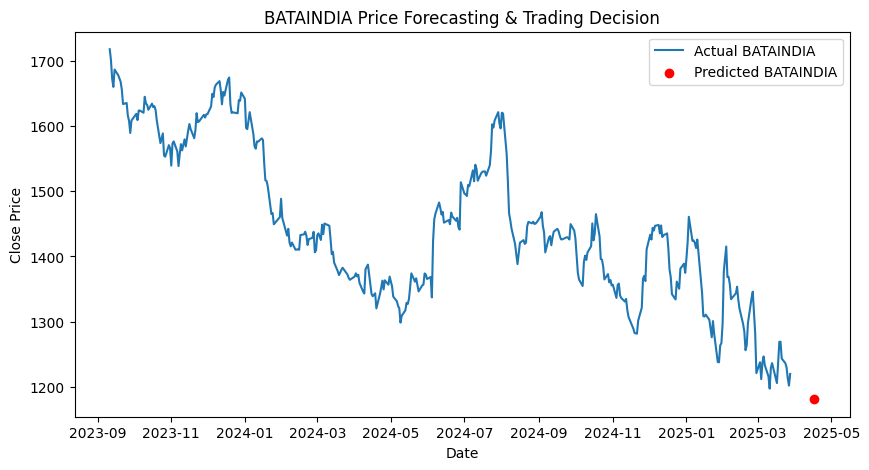

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([2, 1, 1])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
The attention mask and

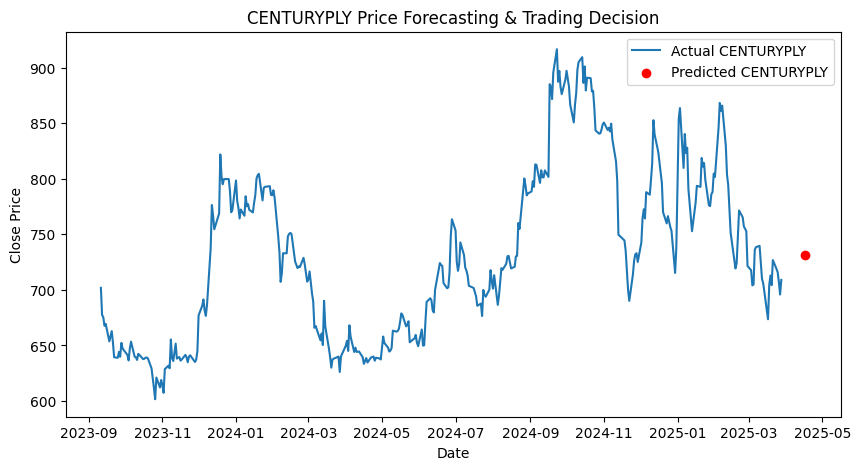

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


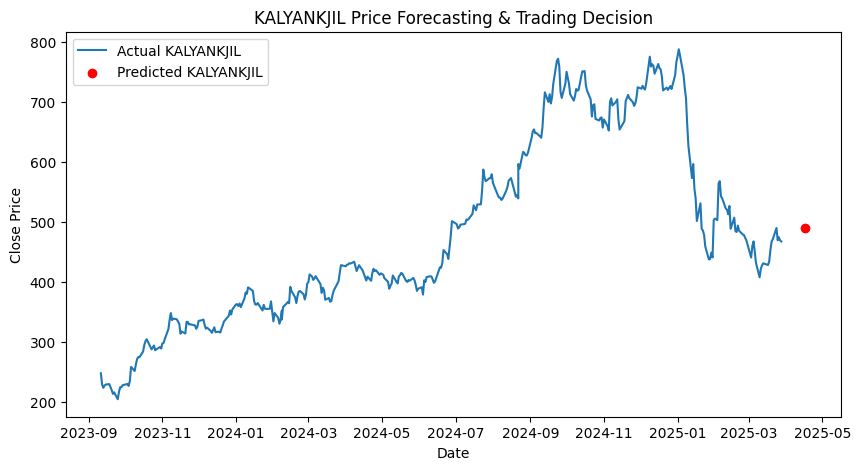

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([3, 1, 1])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
The attention mask and

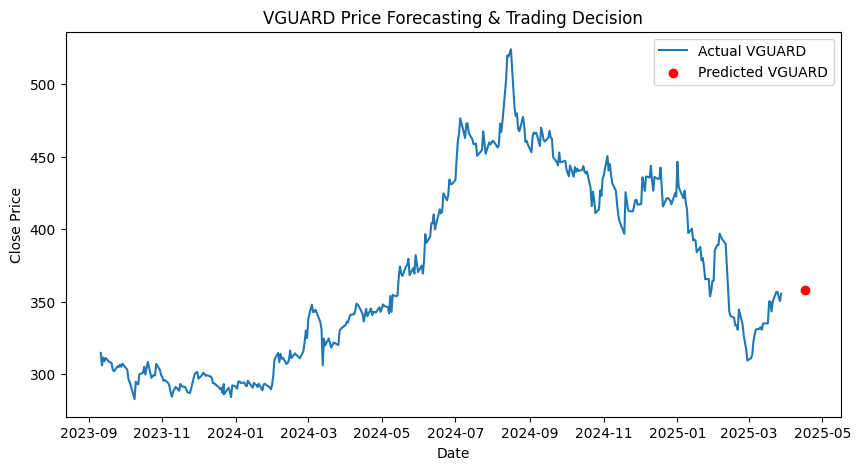

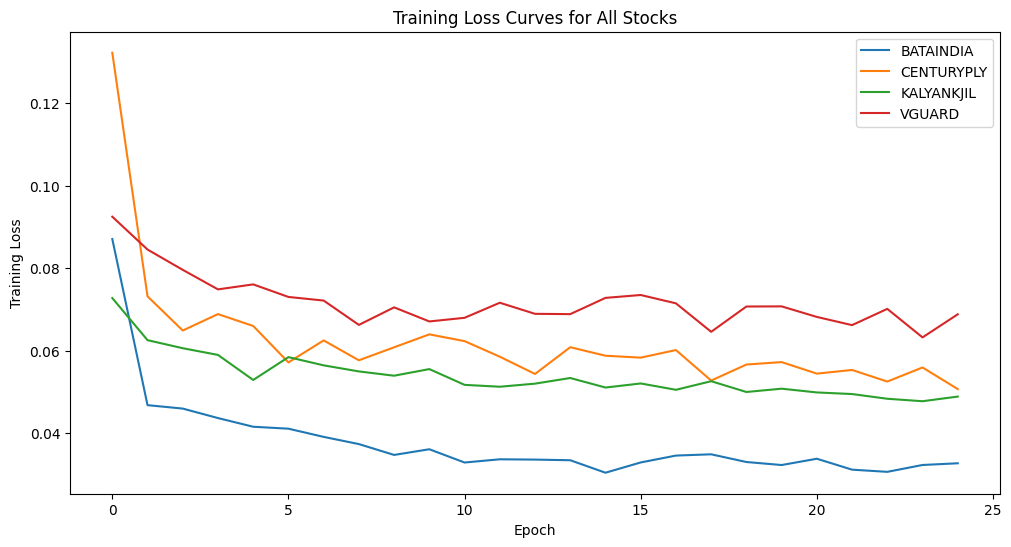

     Stock  Predicted Close      MSE  R-squared     MSLE     MSPE Action    Trend                                                                                                                                                                                                                               Detailed Decision
 BATAINDIA      1181.120932 0.308198   0.691802 0.000572 0.055545   Sell Downward The predicted trend for the stock is Downward and the recommended action is to Sell.\n\nThe stock is currently trading at $1.00 per share.\n\nThe stock is currently trading at $1.00 per share.\n\nThe stock is currently trading at $1.00 per
CENTURYPLY       731.008232 0.239708   0.760292 0.001079 0.113309    Buy   Upward                The predicted trend for the stock is Upward and the recommended action is to Buy.\n\nThe stock is up by about 10% in the last 24 hours.\n\nThe stock is up by about 10% in the last 24 hours.\n\nThe stock is up by about 10% in
KALYANKJIL       489.074845 0.6529

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import datetime
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# ===============================
# Sequence-to-Prediction Transformer Model
# ===============================
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.input_proj(src)
        output = self.transformer_encoder(src)
        output = self.fc_out(output[:, -1, :])
        return output


class StockDataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        return (self.data[idx:idx+self.sequence_length], self.data[idx+self.sequence_length])

def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df.rename(columns=lambda x: x.strip(), inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
    df['close'] = df['close'].astype(str).str.replace(',', '').astype(float)
    df = df[['Date', 'close']]
    df.sort_values('Date', inplace=True)
    return df

def mean_squared_log_error(y_true, y_pred):
    return np.mean((np.log1p(y_true) - np.log1p(y_pred))**2)

def mean_squared_percentage_error(y_true, y_pred):
    epsilon = 1e-10
    return np.mean(((y_true - y_pred) / (y_true + epsilon))**2) * 100

def train_model(train_loader, input_dim, epochs=25, lr=0.00002):
    model = TransformerModel(input_dim=input_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    epoch_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        count = 0
        for seq, target in train_loader:
            optimizer.zero_grad()
            output = model(seq.float())
            loss = criterion(output, target.float().unsqueeze(1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            count += 1
        avg_loss = epoch_loss / count
        epoch_losses.append(avg_loss)
    return model, epoch_losses

# ===============================
# Prediction Function
# ===============================
def predict(model, data, sequence_length=30):
    last_sequence = torch.tensor(data[-sequence_length:]).float().unsqueeze(0)
    predicted_price = model(last_sequence).item()
    return predicted_price

# ===============================
# Advanced AI Agent Architecture
# ===============================
class AdvancedAIAgent:
    def __init__(self):
        self.short_term_memory = []
        self.long_term_memory = {}
        self.episodic_memory = {}
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        self.llm = GPT2LMHeadModel.from_pretrained("gpt2")

    def update_memory(self, key, value, memory_type="long-term"):
        if memory_type == "short-term":
            self.short_term_memory.append(value)
        elif memory_type == "long-term":
            self.long_term_memory[key] = value
        elif memory_type == "episodic":
            self.episodic_memory[key] = value

    def make_decision(self, actual_price, predicted_price):
        self.update_memory('actual_price', actual_price,
                           memory_type="episodic")
        self.update_memory('predicted_price', predicted_price,
                           memory_type="episodic")
        self.update_memory('last_prediction', predicted_price,
                           memory_type="short-term")

        price_diff = predicted_price - actual_price
        if price_diff > 0:
            action = "Buy"
            trend = "Upward"
        elif price_diff < 0:
            action = "Sell"
            trend = "Downward"
        else:
            action = "Hold"
            trend = "Stable"

        # LLM-Based Detailed Justification
        prompt = (f"The predicted trend for the stock is {trend} and the recommended action is to {action}.")
        inputs = self.tokenizer.encode(prompt, return_tensors="pt")
        outputs = self.llm.generate(inputs, max_length=60,
                                    num_return_sequences=1)
        decision_text = self.tokenizer.decode(outputs[0],
                                    skip_special_tokens=True)

        return action, trend, decision_text

# ===============================
# Main Execution
# ===============================
if __name__ == "__main__":
    csv_files = ['BATAINDIA.csv','CENTURYPLY.csv','KALYANKJIL.csv','VGUARD.csv']
    future_date = input("Enter future date (DD-MM-YYYY): ")
    future_date = datetime.datetime.strptime(future_date, "%d-%m-%Y")
    results = []

    ai_agent = AdvancedAIAgent()

    all_training_losses = {}

    for file in csv_files:
        stock_name = os.path.basename(file).replace(".csv", "")
        df = load_and_preprocess_data(file)
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df[['close']])

        # Splitting the data into 80% training and 20% testing
        train_size = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:train_size]
        test_data = scaled_data[train_size:]

        train_dataset = StockDataset(train_data)
        test_dataset = StockDataset(test_data)

        train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

        model, epoch_losses = train_model(train_loader, input_dim=1)
        all_training_losses[stock_name] = epoch_losses

        # Predictions
        predicted_prices = []
        actual_prices = []
        model.eval()
        with torch.no_grad():
            for seq, target in test_loader:
                output = model(seq.float())
                predicted_prices.extend(output.numpy().flatten())
                actual_prices.extend(target.numpy().flatten())

        predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1)).flatten()
        actual_prices = scaler.inverse_transform(np.array(actual_prices).reshape(-1, 1)).flatten()

        predicted_price = predict(model, scaled_data)
        predicted_price = scaler.inverse_transform([[predicted_price]])[0][0]

        actual_price = df['close'].iloc[-1]
        r2 = r2_score(actual_prices, predicted_prices)
        mse=1-r2
        mape = mean_absolute_percentage_error(actual_prices, predicted_prices) * 100

        msle = mean_squared_log_error(actual_prices, predicted_prices)
        mspe = mean_squared_percentage_error(actual_prices, predicted_prices)

        action, trend, decision_text = ai_agent.make_decision(actual_price, predicted_price)

        results.append([
            stock_name, predicted_price, mse, r2, msle, mspe,
            action, trend, decision_text
        ])

        # Plot for each stock
        plt.figure(figsize=(10, 5))
        plt.plot(df['Date'], df['close'], label=f"Actual {stock_name}")
        plt.scatter([future_date], [predicted_price], color='red', label=f"Predicted {stock_name}")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(f"{stock_name} Price Forecasting & Trading Decision")
        plt.legend()
        plt.show()

    # Plot training loss curves for all stocks
    plt.figure(figsize=(12, 6))
    for stock, losses in all_training_losses.items():
        plt.plot(losses, label=stock)
    plt.title("Training Loss Curves for All Stocks")
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.legend()
    plt.show()

    # Results DataFrame
    results_df = pd.DataFrame(results, columns=[
        'Stock', 'Predicted Close', 'MSE', 'R-squared', 'MSLE', 'MSPE',
        'Action', 'Trend', 'Detailed Decision'
    ])
    print(results_df.to_string(index=False))


CODE 4: SEQUENCE TO PREDICTION TRANSFORMER WITH Advanced AI Agent Architecture (WITH OPEN, HIGH, LOW, CLOSE AS INPUT FEATURE)

Enter future date (DD-MM-YYYY): 17-04-2025


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


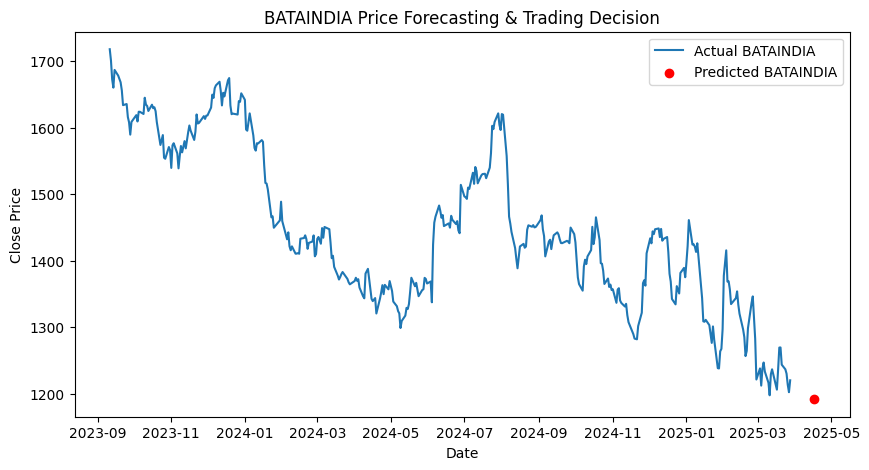

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


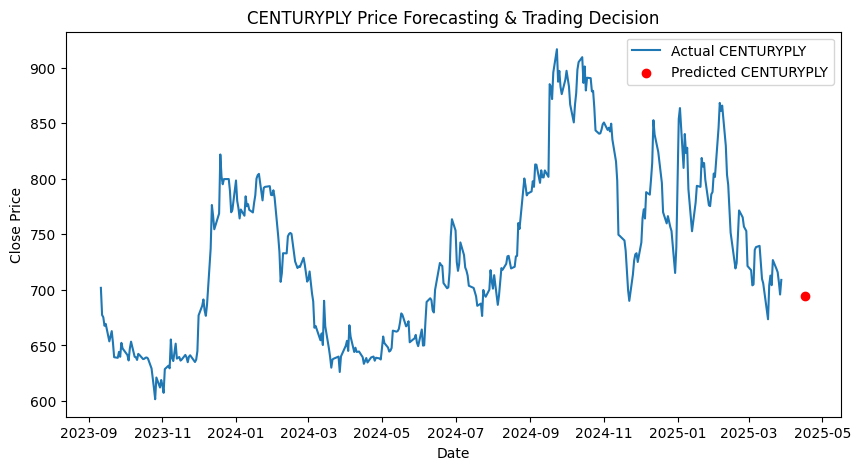

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


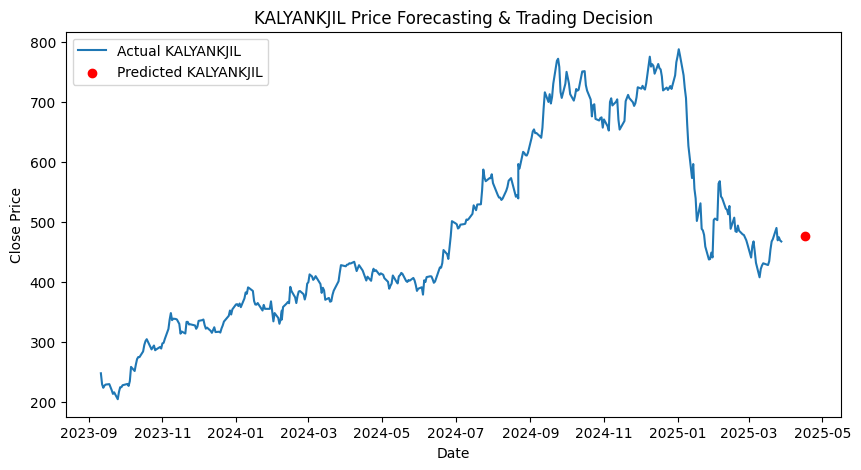

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


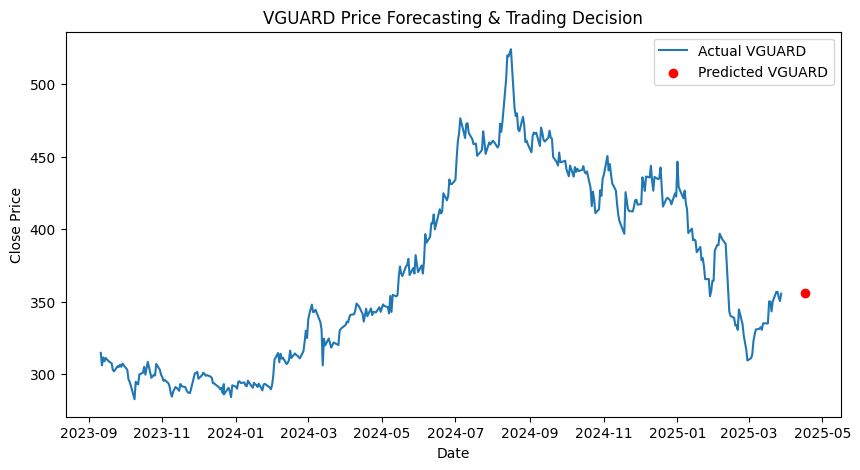

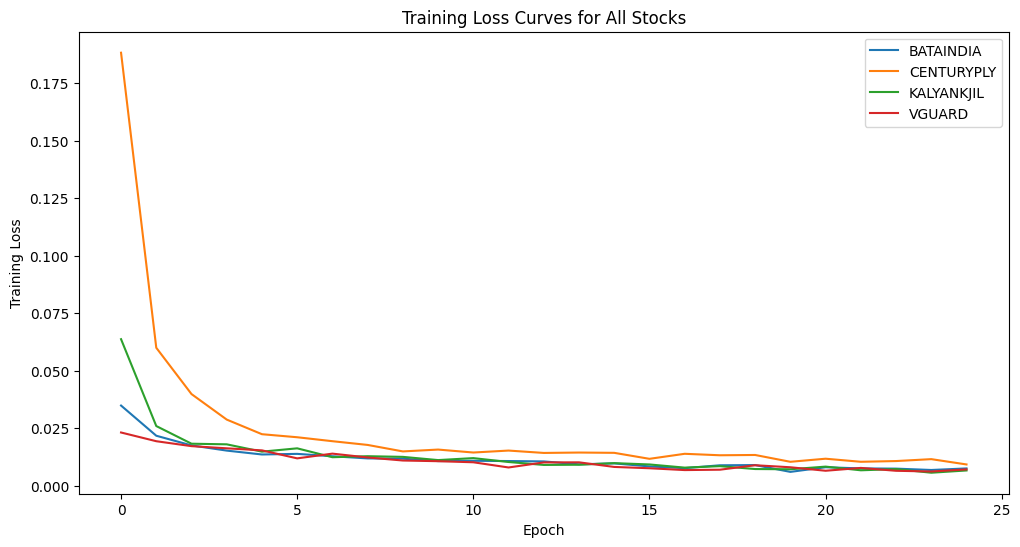

     Stock  Predicted Close      MSE  R-squared     MSLE     MSPE Action    Trend                                                                                                                                                                                                                               Detailed Decision
 BATAINDIA      1191.470453 0.322012   0.677988 0.000566 0.055938   Sell Downward The predicted trend for the stock is Downward and the recommended action is to Sell.\n\nThe stock is currently trading at $1.00 per share.\n\nThe stock is currently trading at $1.00 per share.\n\nThe stock is currently trading at $1.00 per
CENTURYPLY       694.863791 0.221944   0.778056 0.000951 0.098078   Sell Downward The predicted trend for the stock is Downward and the recommended action is to Sell.\n\nThe stock is currently trading at $1.00 per share.\n\nThe stock is currently trading at $1.00 per share.\n\nThe stock is currently trading at $1.00 per
KALYANKJIL       475.785795 0.4040

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import datetime
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# ===============================
# Sequence-to-Prediction Transformer Model
# ===============================
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.input_proj(src)
        output = self.transformer_encoder(src)
        output = self.fc_out(output[:, -1, :])
        return output


class StockDataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        seq = self.data[idx : idx + self.sequence_length]
        target = self.data[idx + self.sequence_length][3]  # CLOSE IS AT INDEX 3
        return seq, target


def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df.rename(columns=lambda x: x.strip(), inplace=True)

    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

    # Clean numeric fields
    for col in ['OPEN', 'HIGH', 'LOW', 'close']:
        df[col] = df[col].astype(str).str.replace(',', '').astype(float)

    df = df[['Date', 'OPEN', 'HIGH', 'LOW', 'close']]
    df.sort_values('Date', inplace=True)
    return df


def mean_squared_log_error(y_true, y_pred):
    return np.mean((np.log1p(y_true) - np.log1p(y_pred))**2)


def mean_squared_percentage_error(y_true, y_pred):
    epsilon = 1e-10
    return np.mean(((y_true - y_pred) / (y_true + epsilon))**2) * 100


def train_model(train_loader, input_dim, epochs=25, lr=0.00002):
    model = TransformerModel(input_dim=input_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    epoch_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        count = 0
        for seq, target in train_loader:
            optimizer.zero_grad()
            output = model(seq.float())
            loss = criterion(output, target.float().unsqueeze(1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            count += 1
        avg_loss = epoch_loss / count
        epoch_losses.append(avg_loss)

    return model, epoch_losses


def predict(model, data, sequence_length=30):
    last_sequence = torch.tensor(data[-sequence_length:]).float().unsqueeze(0)
    predicted_price = model(last_sequence).item()
    return predicted_price


# ===============================
# Advanced AI Agent Architecture
# ===============================
class AdvancedAIAgent:
    def __init__(self):
        self.short_term_memory = []
        self.long_term_memory = {}
        self.episodic_memory = {}
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        self.llm = GPT2LMHeadModel.from_pretrained("gpt2")

    def update_memory(self, key, value, memory_type="long-term"):
        if memory_type == "short-term":
            self.short_term_memory.append(value)
        elif memory_type == "long-term":
            self.long_term_memory[key] = value
        elif memory_type == "episodic":
            self.episodic_memory[key] = value

    def make_decision(self, actual_price, predicted_price):
        self.update_memory('actual_price', actual_price, memory_type="episodic")
        self.update_memory('predicted_price', predicted_price, memory_type="episodic")
        self.update_memory('last_prediction', predicted_price, memory_type="short-term")

        price_diff = predicted_price - actual_price
        if price_diff > 0:
            action = "Buy"
            trend = "Upward"
        elif price_diff < 0:
            action = "Sell"
            trend = "Downward"
        else:
            action = "Hold"
            trend = "Stable"

        prompt = (f"The predicted trend for the stock is {trend} and the recommended action is to {action}.")
        inputs = self.tokenizer.encode(prompt, return_tensors="pt")
        outputs = self.llm.generate(inputs, max_length=60, num_return_sequences=1)
        decision_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        return action, trend, decision_text


# ===============================
# Main Execution
# ===============================
if __name__ == "__main__":
    csv_files = ['BATAINDIA.csv', 'CENTURYPLY.csv', 'KALYANKJIL.csv', 'VGUARD.csv']
    future_date = input("Enter future date (DD-MM-YYYY): ")
    future_date = datetime.datetime.strptime(future_date, "%d-%m-%Y")
    results = []

    ai_agent = AdvancedAIAgent()
    all_training_losses = {}

    for file in csv_files:
        stock_name = os.path.basename(file).replace(".csv", "")
        df = load_and_preprocess_data(file)

        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df[['OPEN', 'HIGH', 'LOW', 'close']])

        # Split 80/20
        train_size = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:train_size]
        test_data = scaled_data[train_size:]

        train_dataset = StockDataset(train_data)
        test_dataset = StockDataset(test_data)

        train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

        # 4 INPUT FEATURES
        model, epoch_losses = train_model(train_loader, input_dim=4)
        all_training_losses[stock_name] = epoch_losses

        # Predictions
        predicted_prices = []
        actual_prices = []
        model.eval()

        with torch.no_grad():
            for seq, target in test_loader:
                output = model(seq.float())
                predicted_prices.extend(output.numpy().flatten())
                actual_prices.extend(target.numpy().flatten())

        # Inverse transform ONLY the close column
        predicted_prices = scaler.inverse_transform(
            np.column_stack([np.zeros(len(predicted_prices)),
                             np.zeros(len(predicted_prices)),
                             np.zeros(len(predicted_prices)),
                             predicted_prices])
        )[:, 3]

        actual_prices = scaler.inverse_transform(
            np.column_stack([np.zeros(len(actual_prices)),
                             np.zeros(len(actual_prices)),
                             np.zeros(len(actual_prices)),
                             actual_prices])
        )[:, 3]

        predicted_price = predict(model, scaled_data)
        predicted_price = scaler.inverse_transform([[0, 0, 0, predicted_price]])[0][3]

        actual_price = df['close'].iloc[-1]

        r2 = r2_score(actual_prices, predicted_prices)
        mse = 1 - r2
        mape = mean_absolute_percentage_error(actual_prices, predicted_prices) * 100

        msle = mean_squared_log_error(actual_prices, predicted_prices)
        mspe = mean_squared_percentage_error(actual_prices, predicted_prices)

        action, trend, decision_text = ai_agent.make_decision(actual_price, predicted_price)

        results.append([
            stock_name, predicted_price, mse, r2, msle, mspe,
            action, trend, decision_text
        ])

        # Plot actual vs predicted point
        plt.figure(figsize=(10, 5))
        plt.plot(df['Date'], df['close'], label=f"Actual {stock_name}")
        plt.scatter([future_date], [predicted_price], color='red', label=f"Predicted {stock_name}")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(f"{stock_name} Price Forecasting & Trading Decision")
        plt.legend()
        plt.show()

    # Training Loss Curves (All Stocks)
    plt.figure(figsize=(12, 6))
    for stock, losses in all_training_losses.items():
        plt.plot(losses, label=stock)
    plt.title("Training Loss Curves for All Stocks")
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.legend()
    plt.show()

    # Final Table
    results_df = pd.DataFrame(results, columns=[
        'Stock', 'Predicted Close', 'MSE', 'R-squared', 'MSLE', 'MSPE',
        'Action', 'Trend', 'Detailed Decision'
    ])
    print(results_df.to_string(index=False))


CODE 5: LSTM WITH close INPUT FEATURES

Enter future date (DD-MM-YYYY): 17-04-2025


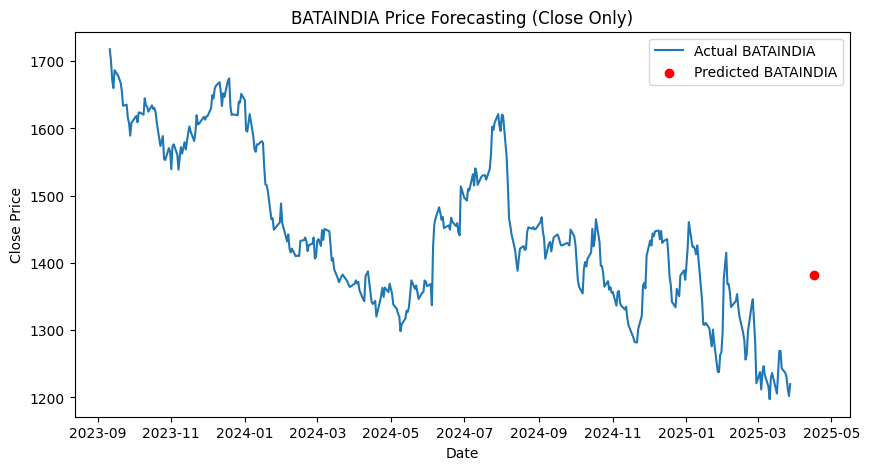

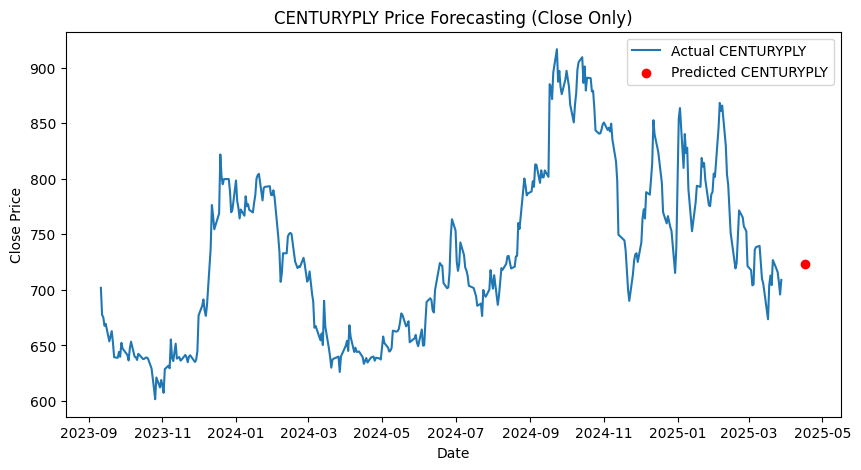

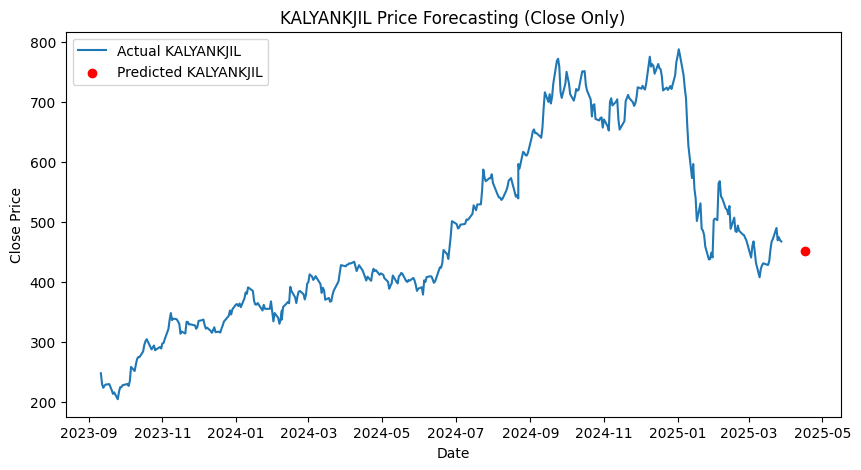

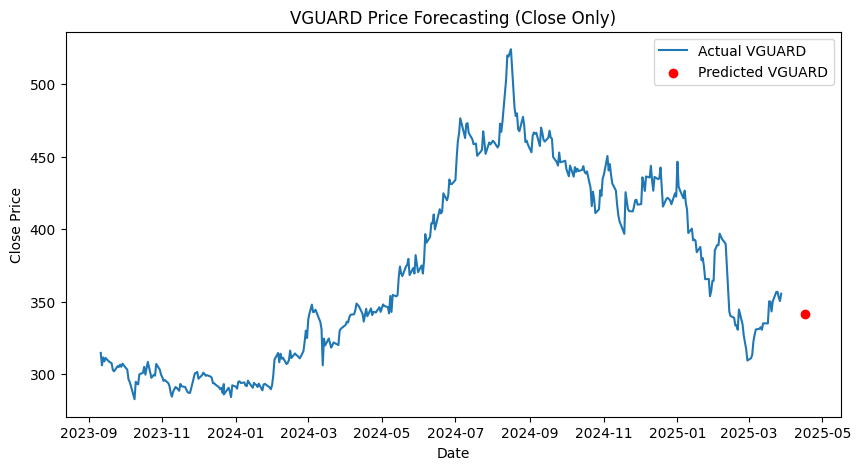

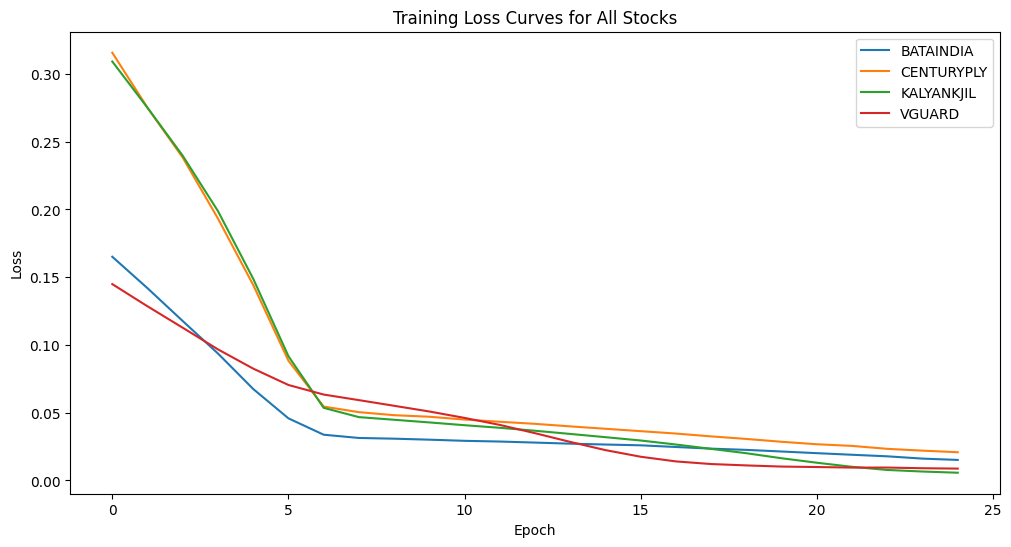

     Stock  Predicted Close      MSE  R-squared     MSLE     MSPE
 BATAINDIA      1381.642163 5.947104  -4.947104 0.010040 1.130453
CENTURYPLY       722.965631 0.607839   0.392161 0.002563 0.255387
KALYANKJIL       451.684152 4.150931  -3.150931 0.019300 2.569836
    VGUARD       341.292678 0.705119   0.294881 0.003131 0.326772


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import datetime

# ===============================
# LSTM MODEL (ONLY CLOSE PRICE)
# ===============================
class LSTMModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


# ===============================
# DATASET USING ONLY CLOSE PRICE
# ===============================
class StockDataset(Dataset):
    def __init__(self, close_prices, sequence_length=30):
        # close_prices expected as 1D numpy array or list of scaled values
        self.close_prices = np.array(close_prices, dtype=np.float32)
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.close_prices) - self.sequence_length

    def __getitem__(self, idx):
        seq = self.close_prices[idx : idx + self.sequence_length]          # shape (seq_len,)
        target = self.close_prices[idx + self.sequence_length]            # scalar
        # Convert to tensors and ensure seq has shape (seq_len, 1)
        seq_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(-1) # (seq_len, 1)
        target_tensor = torch.tensor(target, dtype=torch.float32)        # scalar
        return seq_tensor, target_tensor


# ===============================
# PREPROCESS DATA (KEEP ONLY CLOSE)
# ===============================
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df.rename(columns=lambda x: x.strip(), inplace=True)

    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
    df['close'] = df['close'].astype(str).str.replace(',', '').astype(float)

    df = df[['Date', 'close']]
    df.sort_values('Date', inplace=True)
    return df


# ===============================
# METRICS
# ===============================
def mean_squared_log_error(y_true, y_pred):
    return np.mean((np.log1p(y_true) - np.log1p(y_pred))**2)

def mean_squared_percentage_error(y_true, y_pred):
    epsilon = 1e-10
    return np.mean(((y_true - y_pred) / (y_true + epsilon))**2) * 100


# ===============================
# TRAIN LSTM MODEL
# ===============================
def train_model(train_loader, epochs=25, lr=0.00002, device='cpu'):
    model = LSTMModel(input_dim=1).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    epoch_losses = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        count = 0
        for seq, target in train_loader:
            seq = seq.to(device)                # shape (batch, seq_len, 1)
            target = target.to(device).unsqueeze(1)  # shape (batch, 1)

            optimizer.zero_grad()
            output = model(seq)                 # shape (batch, 1)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            count += 1
        avg_loss = epoch_loss / count if count > 0 else 0.0
        epoch_losses.append(avg_loss)

    return model, epoch_losses


# ===============================
# PREDICT NEXT VALUE
# ===============================
def predict(model, scaled_close, sequence_length=30, device='cpu'):
    # scaled_close: 1D numpy array
    arr = np.array(scaled_close[-sequence_length:], dtype=np.float32)     # (seq_len,)
    last_seq = torch.tensor(arr).unsqueeze(0).unsqueeze(-1).to(device)   # (1, seq_len, 1)
    model.eval()
    with torch.no_grad():
        pred = model(last_seq).cpu().item()
    return pred


# ===============================
# MAIN EXECUTION
# ===============================
if __name__ == "__main__":
    csv_files = ['BATAINDIA.csv', 'CENTURYPLY.csv', 'KALYANKJIL.csv', 'VGUARD.csv']
    future_date = input("Enter future date (DD-MM-YYYY): ")
    future_date = datetime.datetime.strptime(future_date, "%d-%m-%Y")
    results = []
    all_training_losses = {}

    # device selection (CPU only here; change if you want GPU)
    device = 'cpu'

    for file in csv_files:
        stock_name = os.path.basename(file).replace(".csv", "")
        df = load_and_preprocess_data(file)

        scaler = MinMaxScaler()
        scaled_close = scaler.fit_transform(df[['close']]).flatten()  # 1D array

        # 80-20 split
        train_size = int(len(scaled_close) * 0.8)
        train_close = scaled_close[:train_size]
        test_close = scaled_close[train_size:]

        train_dataset = StockDataset(train_close)
        test_dataset = StockDataset(test_close)

        train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

        # Train LSTM
        model, epoch_losses = train_model(train_loader, device=device)
        all_training_losses[stock_name] = epoch_losses

        # Test predictions
        predicted_prices = []
        actual_prices = []
        model.eval()

        with torch.no_grad():
            for seq, target in test_loader:
                seq = seq.to(device)                     # (batch, seq_len, 1)
                output = model(seq)                      # (batch, 1)
                out_np = output.cpu().numpy().flatten()  # (batch,)
                predicted_prices.extend(out_np)
                actual_prices.extend(target.numpy().flatten())

        # Inverse scaling
        predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1)).flatten()
        actual_prices = scaler.inverse_transform(np.array(actual_prices).reshape(-1, 1)).flatten()

        predicted_price = predict(model, scaled_close, device=device)
        predicted_price = scaler.inverse_transform([[predicted_price]])[0][0]

        # Metrics
        r2 = r2_score(actual_prices, predicted_prices) if len(actual_prices) > 0 else float('nan')
        mse = 1 - r2 if not np.isnan(r2) else float('nan')
        mape = mean_absolute_percentage_error(actual_prices, predicted_prices) * 100 if len(actual_prices) > 0 else float('nan')
        msle = mean_squared_log_error(actual_prices, predicted_prices) if len(actual_prices) > 0 else float('nan')
        mspe = mean_squared_percentage_error(actual_prices, predicted_prices) if len(actual_prices) > 0 else float('nan')

        results.append([stock_name, predicted_price, mse, r2, msle, mspe])

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(df['Date'], df['close'], label=f"Actual {stock_name}")
        plt.scatter([future_date], [predicted_price], color='red', label=f"Predicted {stock_name}")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(f"{stock_name} Price Forecasting (Close Only)")
        plt.legend()
        plt.show()

    # Plot Training Losses
    plt.figure(figsize=(12, 6))
    for stock, losses in all_training_losses.items():
        plt.plot(losses, label=stock)
    plt.title("Training Loss Curves for All Stocks")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Final Output Table
    results_df = pd.DataFrame(results, columns=[
        'Stock', 'Predicted Close', 'MSE', 'R-squared', 'MSLE', 'MSPE'
    ])
    print(results_df.to_string(index=False))


CODE 6: LSTM WITH ALL 4 INPUT FEATURES

Enter future date (DD-MM-YYYY): 17-04-2025


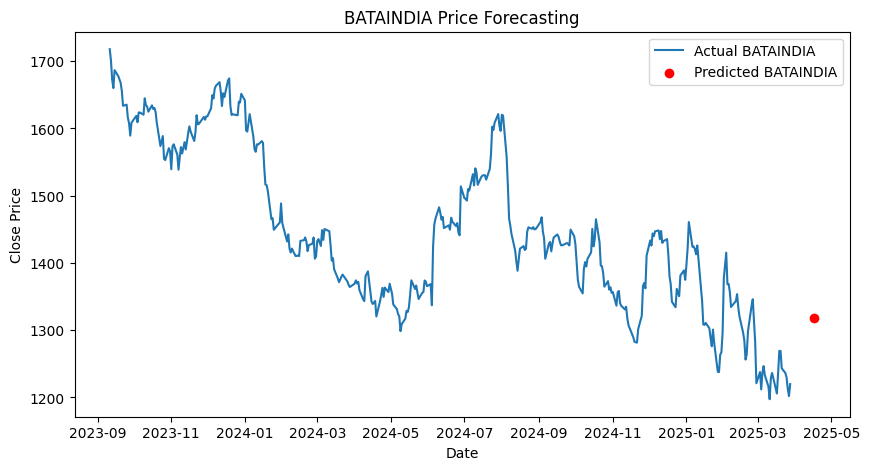

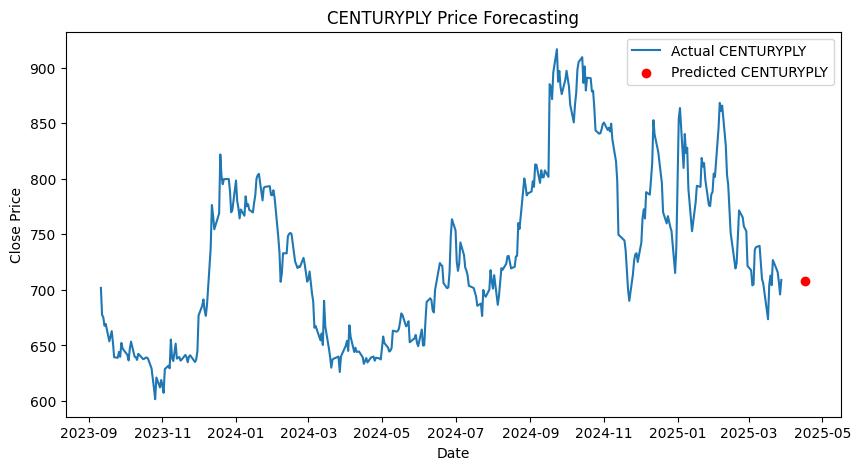

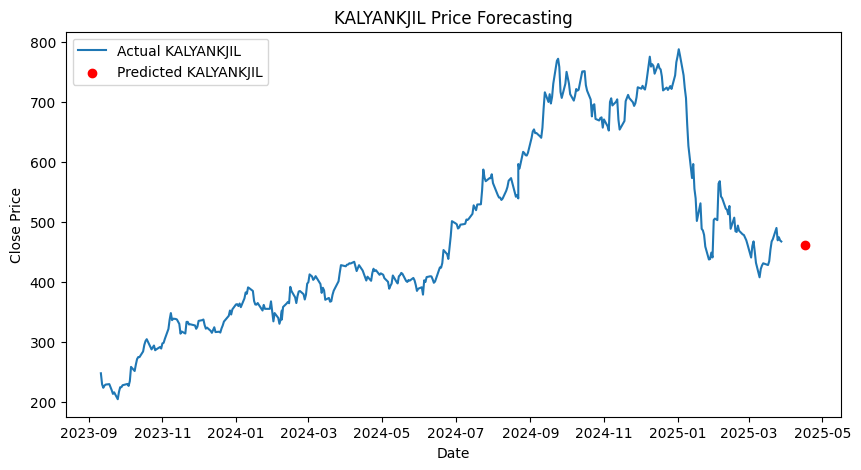

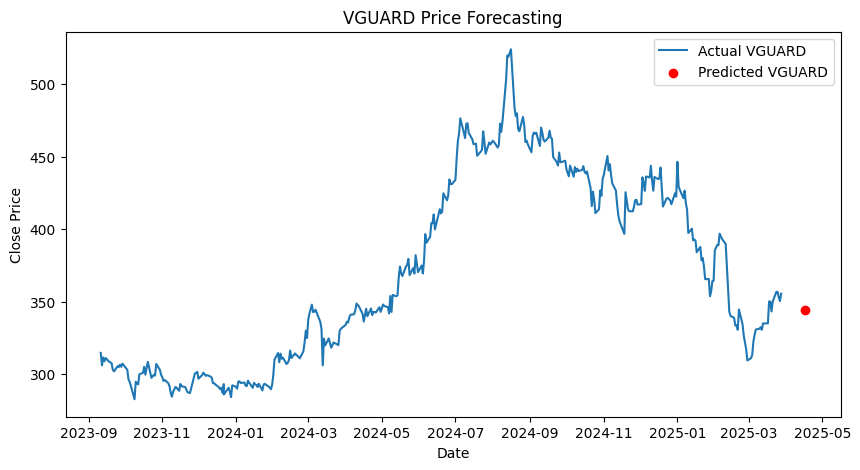

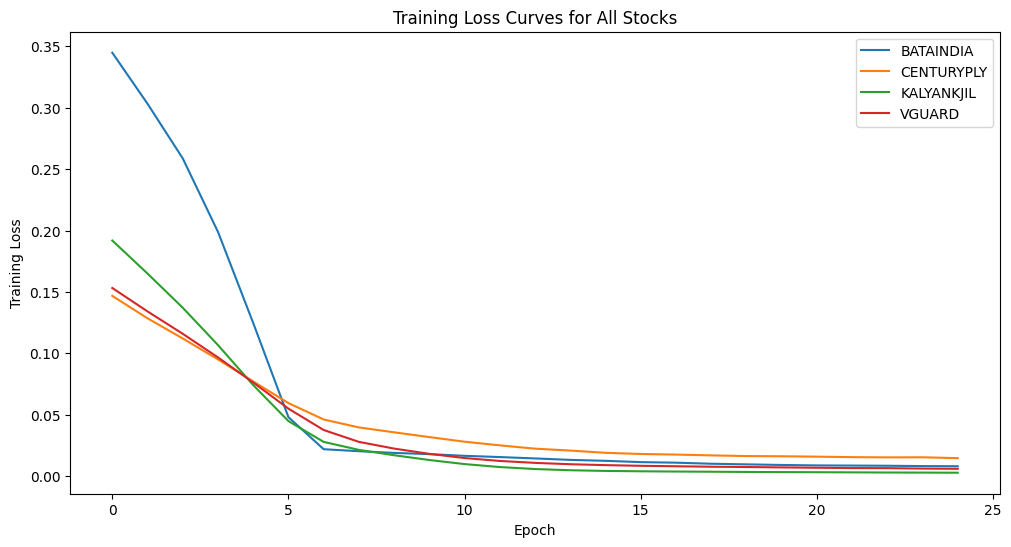

     Stock  Predicted Close      MSE  R-squared     MSLE     MSPE
 BATAINDIA      1317.695489 2.367203  -1.367203 0.004169 0.451541
CENTURYPLY       708.353010 0.550987   0.449013 0.002271 0.223006
KALYANKJIL       461.031339 4.783305  -3.783305 0.022330 2.993825
    VGUARD       344.357805 0.830808   0.169192 0.003630 0.386831


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import datetime

# ===============================
# Simple LSTM Model for Price Prediction
# ===============================
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


class StockDataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        seq = self.data[idx : idx + self.sequence_length]
        target = self.data[idx + self.sequence_length][3]  # CLOSE is at index 3
        return seq, target


def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df.rename(columns=lambda x: x.strip(), inplace=True)

    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

    for col in ['OPEN', 'HIGH', 'LOW', 'close']:
        df[col] = df[col].astype(str).str.replace(',', '').astype(float)

    df = df[['Date', 'OPEN', 'HIGH', 'LOW', 'close']]
    df.sort_values('Date', inplace=True)
    return df


def mean_squared_log_error(y_true, y_pred):
    return np.mean((np.log1p(y_true) - np.log1p(y_pred))**2)


def mean_squared_percentage_error(y_true, y_pred):
    epsilon = 1e-10
    return np.mean(((y_true - y_pred) / (y_true + epsilon))**2) * 100


# ===============================
# Train LSTM Model
# ===============================
def train_model(train_loader, input_dim, epochs=25, lr=0.00002):
    model = LSTMModel(input_dim=input_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    epoch_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        count = 0
        for seq, target in train_loader:
            optimizer.zero_grad()
            output = model(seq.float())
            loss = criterion(output, target.float().unsqueeze(1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            count += 1
        avg_loss = epoch_loss / count
        epoch_losses.append(avg_loss)

    return model, epoch_losses


def predict(model, data, sequence_length=30):
    last_sequence = torch.tensor(data[-sequence_length:]).float().unsqueeze(0)
    predicted_price = model(last_sequence).item()
    return predicted_price


# ===============================
# Main Execution
# ===============================
if __name__ == "__main__":
    csv_files = ['BATAINDIA.csv', 'CENTURYPLY.csv', 'KALYANKJIL.csv', 'VGUARD.csv']
    future_date = input("Enter future date (DD-MM-YYYY): ")
    future_date = datetime.datetime.strptime(future_date, "%d-%m-%Y")
    results = []

    all_training_losses = {}

    for file in csv_files:
        stock_name = os.path.basename(file).replace(".csv", "")
        df = load_and_preprocess_data(file)

        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df[['OPEN', 'HIGH', 'LOW', 'close']])

        train_size = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:train_size]
        test_data = scaled_data[train_size:]

        train_dataset = StockDataset(train_data)
        test_dataset = StockDataset(test_data)

        train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

        # 4 input features
        model, epoch_losses = train_model(train_loader, input_dim=4)
        all_training_losses[stock_name] = epoch_losses

        predicted_prices = []
        actual_prices = []

        model.eval()
        with torch.no_grad():
            for seq, target in test_loader:
                output = model(seq.float())
                predicted_prices.extend(output.numpy().flatten())
                actual_prices.extend(target.numpy().flatten())

        # Inverse-transform close
        predicted_prices = scaler.inverse_transform(
            np.column_stack([np.zeros(len(predicted_prices)),
                             np.zeros(len(predicted_prices)),
                             np.zeros(len(predicted_prices)),
                             predicted_prices])
        )[:, 3]

        actual_prices = scaler.inverse_transform(
            np.column_stack([np.zeros(len(actual_prices)),
                             np.zeros(len(actual_prices)),
                             np.zeros(len(actual_prices)),
                             actual_prices])
        )[:, 3]

        predicted_price = predict(model, scaled_data)
        predicted_price = scaler.inverse_transform([[0, 0, 0, predicted_price]])[0][3]

        actual_price = df['close'].iloc[-1]

        r2 = r2_score(actual_prices, predicted_prices)
        mse = 1 - r2
        mape = mean_absolute_percentage_error(actual_prices, predicted_prices) * 100

        msle = mean_squared_log_error(actual_prices, predicted_prices)
        mspe = mean_squared_percentage_error(actual_prices, predicted_prices)

        results.append([
            stock_name, predicted_price, mse, r2, msle, mspe
        ])

        # Plot actual vs predicted
        plt.figure(figsize=(10, 5))
        plt.plot(df['Date'], df['close'], label=f"Actual {stock_name}")
        plt.scatter([future_date], [predicted_price], color='red', label=f"Predicted {stock_name}")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(f"{stock_name} Price Forecasting")
        plt.legend()
        plt.show()

    # Training Loss Curves
    plt.figure(figsize=(12, 6))
    for stock, losses in all_training_losses.items():
        plt.plot(losses, label=stock)
    plt.title("Training Loss Curves for All Stocks")
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.legend()
    plt.show()

    results_df = pd.DataFrame(results, columns=[
        'Stock', 'Predicted Close', 'MSE', 'R-squared', 'MSLE', 'MSPE'
    ])
    print(results_df.to_string(index=False))


CODE 7: GRU WITH CLOSE AS INPUT FEATURE

Enter future date (DD-MM-YYYY): 17-04-2025


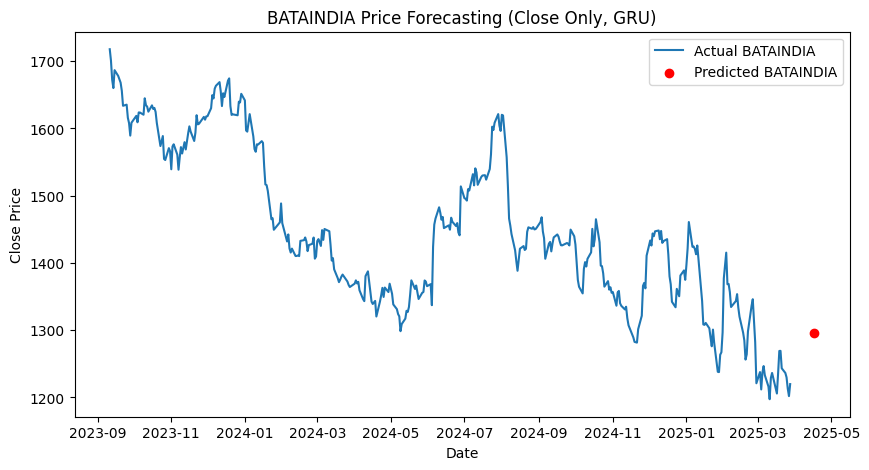

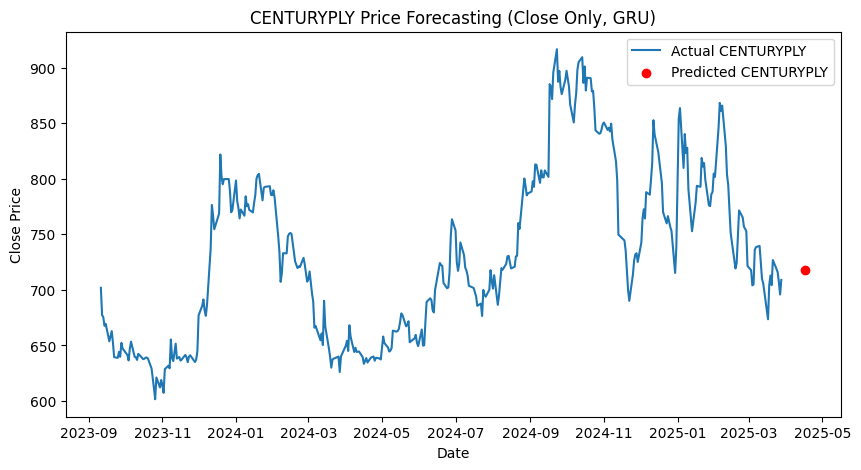

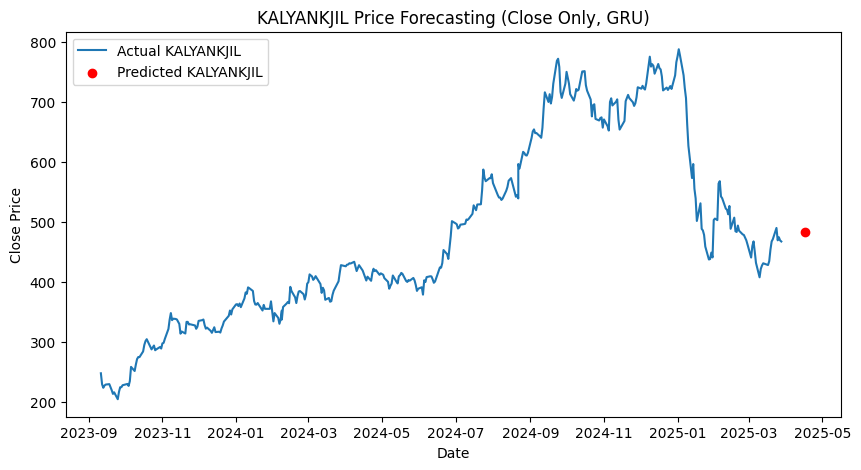

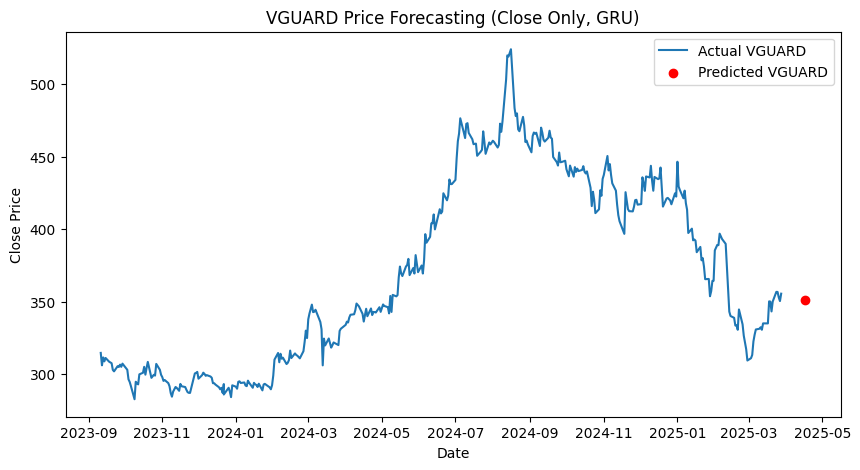

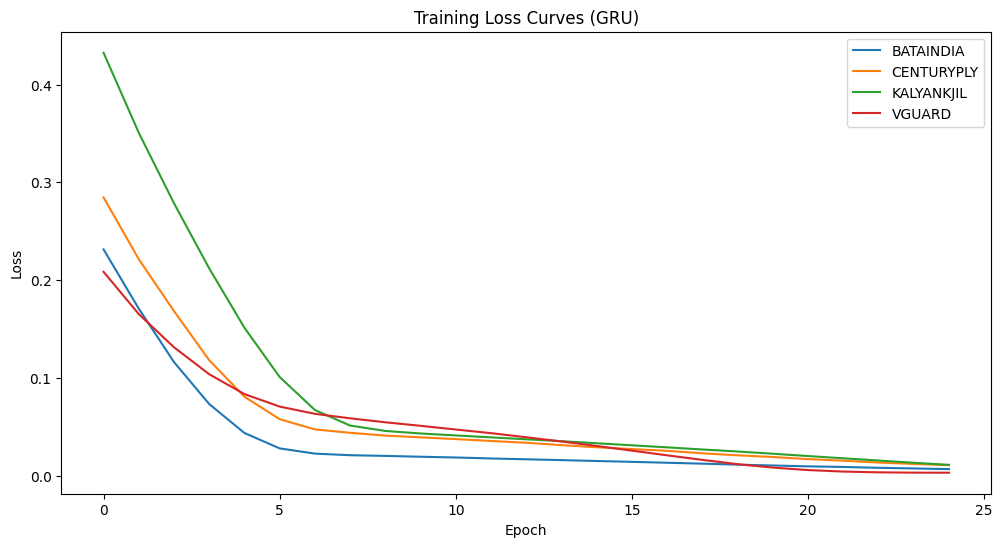

     Stock  Predicted Close      MSE  R-squared     MSLE     MSPE
 BATAINDIA      1296.076941 1.911817  -0.911817 0.003371 0.361694
CENTURYPLY       718.286441 0.429070   0.570930 0.001800 0.180810
KALYANKJIL       482.884285 1.417837  -0.417837 0.007899 0.881652
    VGUARD       351.210012 0.797427   0.202573 0.003478 0.376344


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import datetime

# ===============================
# GRU MODEL (ONLY CLOSE PRICE)
# ===============================
class GRUModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.gru(x)         # (batch, seq_len, hidden)
        out = self.fc(out[:, -1, :]) # last time step
        return out


# ===============================
# DATASET USING ONLY CLOSE PRICE
# ===============================
class StockDataset(Dataset):
    def __init__(self, close_prices, sequence_length=30):
        self.close_prices = np.array(close_prices, dtype=np.float32)
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.close_prices) - self.sequence_length

    def __getitem__(self, idx):
        seq = self.close_prices[idx : idx + self.sequence_length]
        target = self.close_prices[idx + self.sequence_length]

        seq_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(-1)
        target_tensor = torch.tensor(target, dtype=torch.float32)

        return seq_tensor, target_tensor


# ===============================
# PREPROCESS DATA (KEEP ONLY CLOSE)
# ===============================
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df.rename(columns=lambda x: x.strip(), inplace=True)

    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
    df['close'] = df['close'].astype(str).str.replace(',', '').astype(float)

    df = df[['Date', 'close']]
    df.sort_values('Date', inplace=True)
    return df


# ===============================
# METRICS
# ===============================
def mean_squared_log_error(y_true, y_pred):
    return np.mean((np.log1p(y_true) - np.log1p(y_pred))**2)

def mean_squared_percentage_error(y_true, y_pred):
    epsilon = 1e-10
    return np.mean(((y_true - y_pred) / (y_true + epsilon))**2) * 100


# ===============================
# TRAIN GRU MODEL
# ===============================
def train_model(train_loader, epochs=25, lr=0.00002, device='cpu'):
    model = GRUModel(input_dim=1).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    epoch_losses = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        count = 0

        for seq, target in train_loader:
            seq = seq.to(device)
            target = target.to(device).unsqueeze(1)

            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            count += 1

        epoch_losses.append(epoch_loss / count)

    return model, epoch_losses


# ===============================
# PREDICT NEXT VALUE
# ===============================
def predict(model, scaled_close, sequence_length=30, device='cpu'):
    arr = np.array(scaled_close[-sequence_length:], dtype=np.float32)
    last_seq = torch.tensor(arr).unsqueeze(0).unsqueeze(-1).to(device)

    model.eval()
    with torch.no_grad():
        pred = model(last_seq).cpu().item()
    return pred


# ===============================
# MAIN EXECUTION
# ===============================
if __name__ == "__main__":
    csv_files = ['BATAINDIA.csv', 'CENTURYPLY.csv', 'KALYANKJIL.csv', 'VGUARD.csv']
    future_date = input("Enter future date (DD-MM-YYYY): ")
    future_date = datetime.datetime.strptime(future_date, "%d-%m-%Y")
    results = []
    all_training_losses = {}

    device = 'cpu'

    for file in csv_files:
        stock_name = os.path.basename(file).replace(".csv", "")
        df = load_and_preprocess_data(file)

        scaler = MinMaxScaler()
        scaled_close = scaler.fit_transform(df[['close']]).flatten()

        train_size = int(len(scaled_close) * 0.8)
        train_close = scaled_close[:train_size]
        test_close = scaled_close[train_size:]

        train_dataset = StockDataset(train_close)
        test_dataset = StockDataset(test_close)

        train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

        model, epoch_losses = train_model(train_loader, device=device)
        all_training_losses[stock_name] = epoch_losses

        predicted_prices = []
        actual_prices = []
        model.eval()

        with torch.no_grad():
            for seq, target in test_loader:
                seq = seq.to(device)
                output = model(seq)
                predicted_prices.extend(output.cpu().numpy().flatten())
                actual_prices.extend(target.numpy().flatten())

        predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1)).flatten()
        actual_prices = scaler.inverse_transform(np.array(actual_prices).reshape(-1, 1)).flatten()

        predicted_price = predict(model, scaled_close, device=device)
        predicted_price = scaler.inverse_transform([[predicted_price]])[0][0]

        # Metrics
        r2 = r2_score(actual_prices, predicted_prices) if len(actual_prices) > 0 else float('nan')
        mse = 1 - r2 if not np.isnan(r2) else float('nan')
        mape = mean_absolute_percentage_error(actual_prices, predicted_prices) * 100 if len(actual_prices) > 0 else float('nan')
        msle = mean_squared_log_error(actual_prices, predicted_prices) if len(actual_prices) > 0 else float('nan')
        mspe = mean_squared_percentage_error(actual_prices, predicted_prices) if len(actual_prices) > 0 else float('nan')

        results.append([stock_name, predicted_price, mse, r2, msle, mspe])

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(df['Date'], df['close'], label=f"Actual {stock_name}")
        plt.scatter([future_date], [predicted_price], color='red', label=f"Predicted {stock_name}")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(f"{stock_name} Price Forecasting (Close Only, GRU)")
        plt.legend()
        plt.show()

    # Plot Training Losses
    plt.figure(figsize=(12, 6))
    for stock, losses in all_training_losses.items():
        plt.plot(losses, label=stock)
    plt.title("Training Loss Curves (GRU)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Final Output Table
    results_df = pd.DataFrame(results, columns=[
        'Stock', 'Predicted Close', 'MSE', 'R-squared', 'MSLE', 'MSPE'
    ])
    print(results_df.to_string(index=False))


CODE 8: GRU WITH ALL 4 INPUT FEATURES

Enter future date (DD-MM-YYYY): 17-04-2025


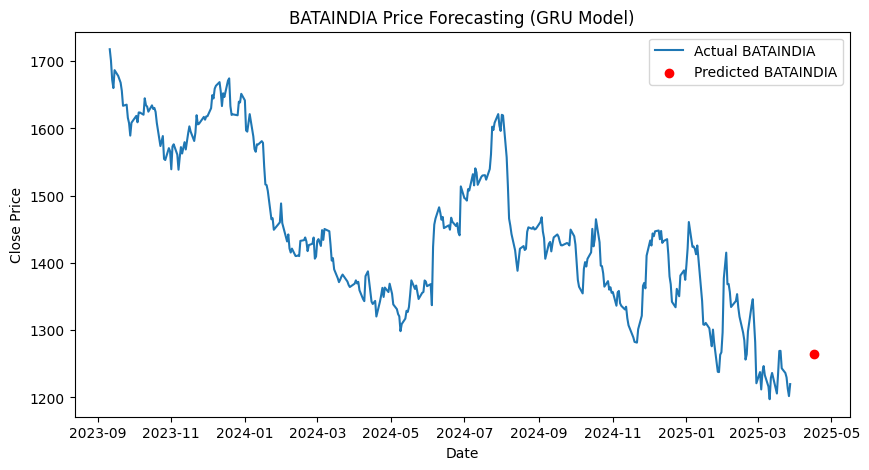

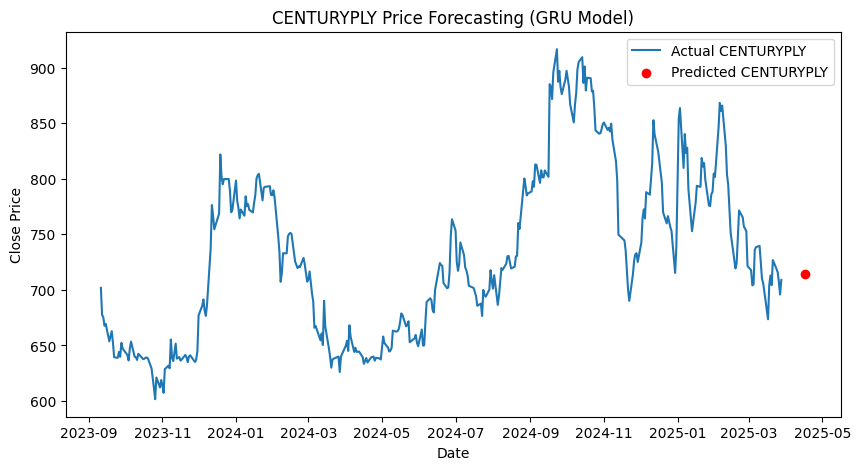

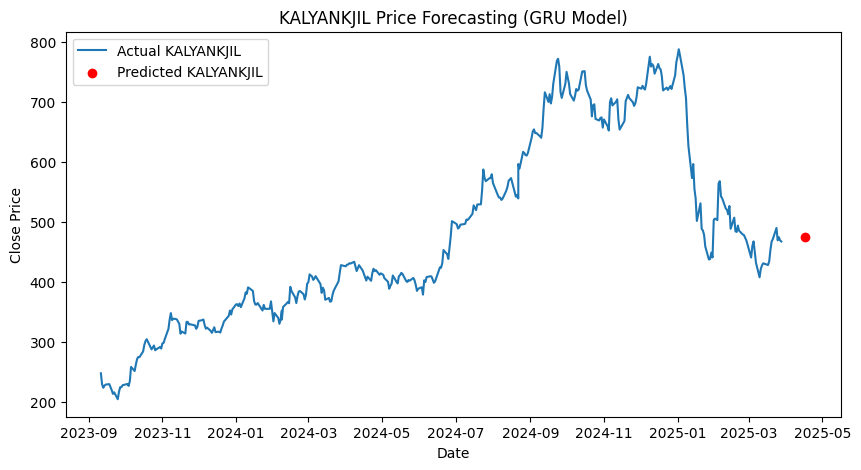

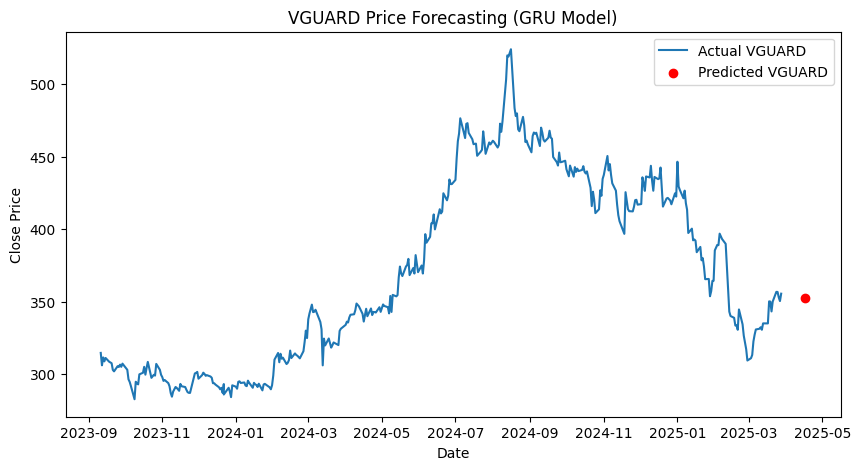

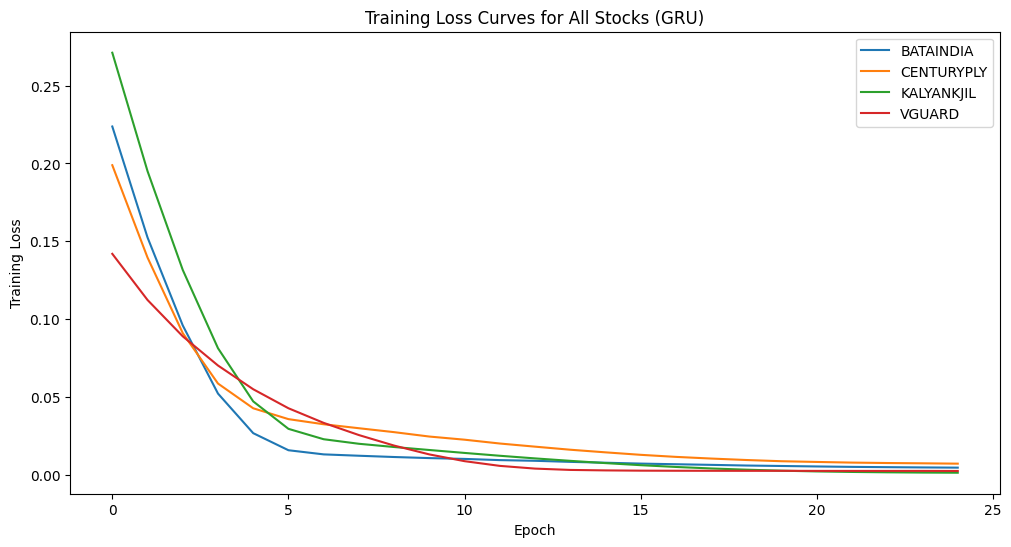

     Stock  Predicted Close      MSE  R-squared     MSLE     MSPE
 BATAINDIA      1264.099123 1.056820  -0.056820 0.001871 0.195104
CENTURYPLY       714.442015 0.442807   0.557193 0.001866 0.194037
KALYANKJIL       475.491966 1.597405  -0.597405 0.008491 0.959279
    VGUARD       352.401212 0.739109   0.260891 0.003216 0.345082


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import datetime

# ===============================
# GRU Model for Price Prediction
# ===============================
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out


class StockDataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        seq = self.data[idx : idx + self.sequence_length]
        target = self.data[idx + self.sequence_length][3]  # CLOSE is at index 3
        return seq, target


def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df.rename(columns=lambda x: x.strip(), inplace=True)

    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

    for col in ['OPEN', 'HIGH', 'LOW', 'close']:
        df[col] = df[col].astype(str).str.replace(',', '').astype(float)

    df = df[['Date', 'OPEN', 'HIGH', 'LOW', 'close']]
    df.sort_values('Date', inplace=True)
    return df


def mean_squared_log_error(y_true, y_pred):
    return np.mean((np.log1p(y_true) - np.log1p(y_pred))**2)


def mean_squared_percentage_error(y_true, y_pred):
    epsilon = 1e-10
    return np.mean(((y_true - y_pred) / (y_true + epsilon))**2) * 100


# ===============================
# Train GRU Model
# ===============================
def train_model(train_loader, input_dim, epochs=25, lr=0.00002):
    model = GRUModel(input_dim=input_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    epoch_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        count = 0
        for seq, target in train_loader:
            optimizer.zero_grad()
            output = model(seq.float())
            loss = criterion(output, target.float().unsqueeze(1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            count += 1
        avg_loss = epoch_loss / count
        epoch_losses.append(avg_loss)

    return model, epoch_losses


def predict(model, data, sequence_length=30):
    last_sequence = torch.tensor(data[-sequence_length:]).float().unsqueeze(0)
    predicted_price = model(last_sequence).item()
    return predicted_price


# ===============================
# Main Execution
# ===============================
if __name__ == "__main__":
    csv_files = ['BATAINDIA.csv', 'CENTURYPLY.csv', 'KALYANKJIL.csv', 'VGUARD.csv']
    future_date = input("Enter future date (DD-MM-YYYY): ")
    future_date = datetime.datetime.strptime(future_date, "%d-%m-%Y")
    results = []

    all_training_losses = {}

    for file in csv_files:
        stock_name = os.path.basename(file).replace(".csv", "")
        df = load_and_preprocess_data(file)

        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df[['OPEN', 'HIGH', 'LOW', 'close']])

        train_size = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:train_size]
        test_data = scaled_data[train_size:]

        train_dataset = StockDataset(train_data)
        test_dataset = StockDataset(test_data)

        train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

        # 4 input features
        model, epoch_losses = train_model(train_loader, input_dim=4)
        all_training_losses[stock_name] = epoch_losses

        predicted_prices = []
        actual_prices = []

        model.eval()
        with torch.no_grad():
            for seq, target in test_loader:
                output = model(seq.float())
                predicted_prices.extend(output.numpy().flatten())
                actual_prices.extend(target.numpy().flatten())

        # Inverse-transform close
        predicted_prices = scaler.inverse_transform(
            np.column_stack([np.zeros(len(predicted_prices)),
                             np.zeros(len(predicted_prices)),
                             np.zeros(len(predicted_prices)),
                             predicted_prices])
        )[:, 3]

        actual_prices = scaler.inverse_transform(
            np.column_stack([np.zeros(len(actual_prices)),
                             np.zeros(len(actual_prices)),
                             np.zeros(len(actual_prices)),
                             actual_prices])
        )[:, 3]

        predicted_price = predict(model, scaled_data)
        predicted_price = scaler.inverse_transform([[0, 0, 0, predicted_price]])[0][3]

        actual_price = df['close'].iloc[-1]

        r2 = r2_score(actual_prices, predicted_prices)
        mse = 1 - r2
        mape = mean_absolute_percentage_error(actual_prices, predicted_prices) * 100

        msle = mean_squared_log_error(actual_prices, predicted_prices)
        mspe = mean_squared_percentage_error(actual_prices, predicted_prices)

        results.append([
            stock_name, predicted_price, mse, r2, msle, mspe
        ])

        # Plot actual vs predicted
        plt.figure(figsize=(10, 5))
        plt.plot(df['Date'], df['close'], label=f"Actual {stock_name}")
        plt.scatter([future_date], [predicted_price], color='red', label=f"Predicted {stock_name}")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(f"{stock_name} Price Forecasting (GRU Model)")
        plt.legend()
        plt.show()

    # Training Loss Curves
    plt.figure(figsize=(12, 6))
    for stock, losses in all_training_losses.items():
        plt.plot(losses, label=stock)
    plt.title("Training Loss Curves for All Stocks (GRU)")
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.legend()
    plt.show()

    results_df = pd.DataFrame(results, columns=[
        'Stock', 'Predicted Close', 'MSE', 'R-squared', 'MSLE', 'MSPE'
    ])
    print(results_df.to_string(index=False))


CODE 9: LSTM+Transformer hybrid MODEL WITH ALL 4 INPUT FEATURES

Enter future date (DD-MM-YYYY): 17-04-2025


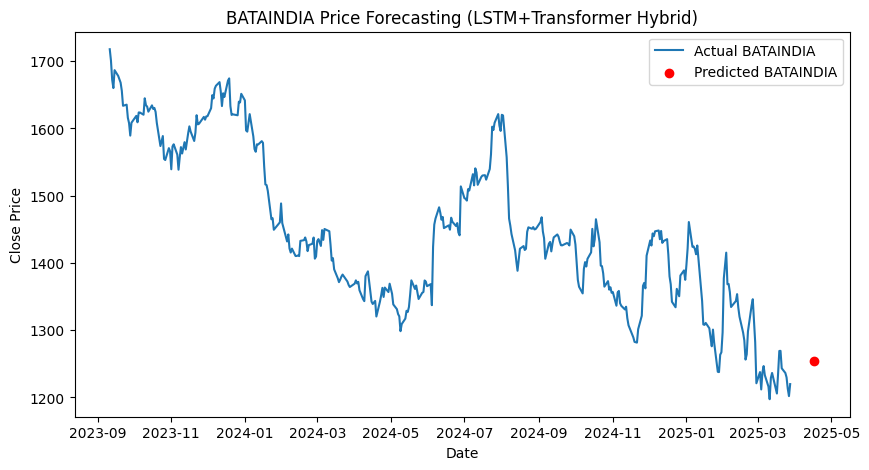

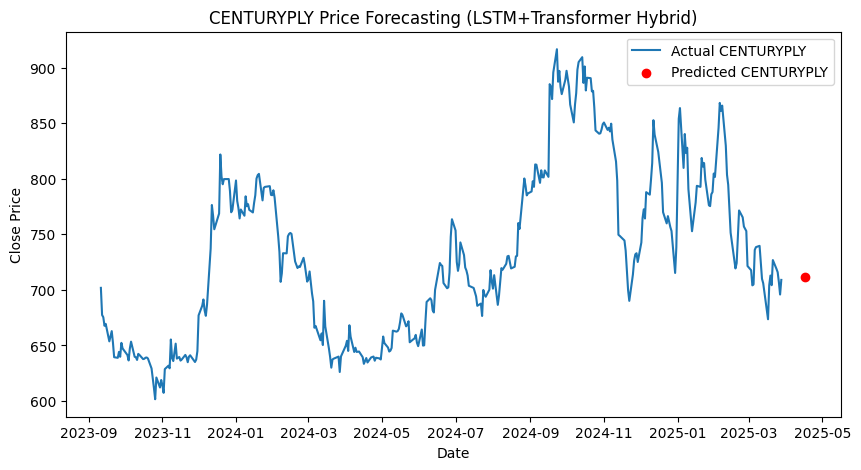

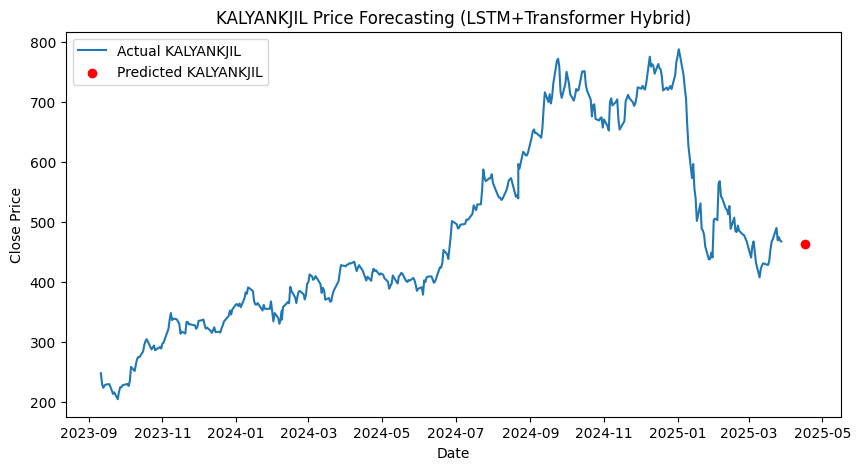

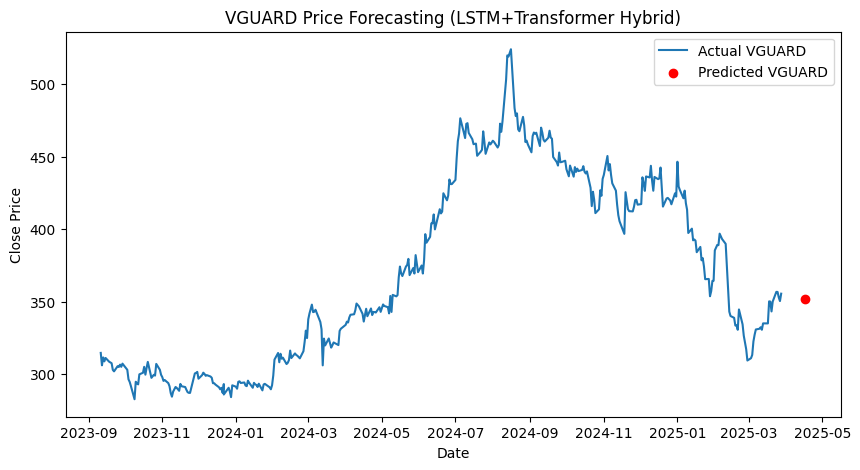

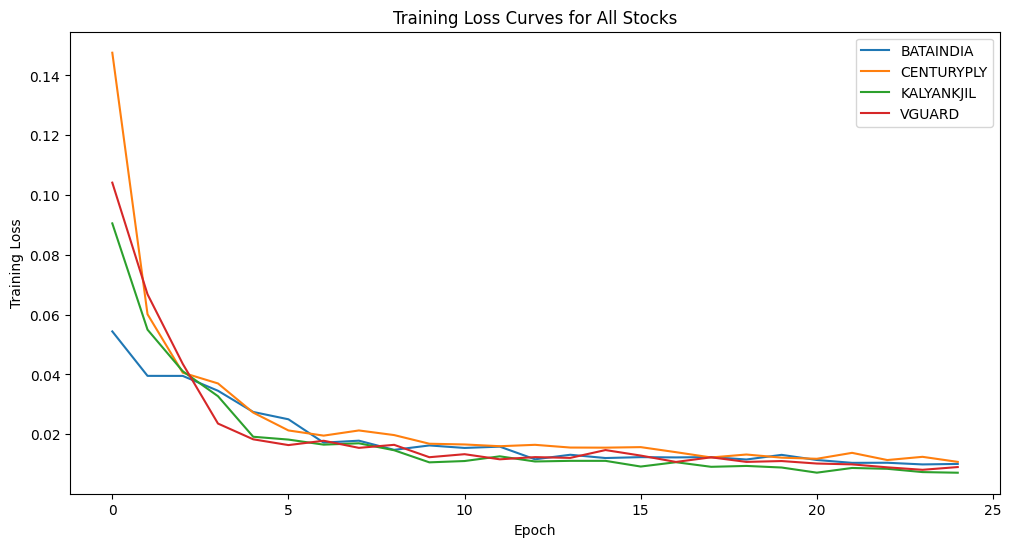

     Stock  Predicted Close      MSE  R-squared     MSLE     MSPE
 BATAINDIA      1254.890499 0.762167   0.237833 0.001352 0.137833
CENTURYPLY       711.787003 0.375114   0.624886 0.001578 0.163721
KALYANKJIL       463.281340 2.146453  -1.146453 0.010886 1.336372
    VGUARD       351.729281 1.173034  -0.173034 0.005006 0.558346


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import datetime

# ===============================
# LSTM + Transformer Hybrid Model
# ===============================
class HybridModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, lstm_layers=2, d_model=128, nhead=4, trans_layers=2, dim_feedforward=256, dropout=0.1):
        """
        input_dim: number of input features (4)
        hidden_dim: LSTM hidden dimension
        lstm_layers: number of LSTM layers
        d_model: transformer model dimension
        nhead: number of attention heads
        trans_layers: number of TransformerEncoder layers
        """
        super(HybridModel, self).__init__()

        # LSTM encoder
        self.lstm = nn.LSTM(input_dim, hidden_dim, lstm_layers, batch_first=True, dropout=dropout if lstm_layers>1 else 0.0)

        # Project LSTM hidden states to transformer d_model
        self.project = nn.Linear(hidden_dim, d_model)
        self.norm = nn.LayerNorm(d_model)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=trans_layers)

        # Final regression head
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        """
        x: (batch, seq_len, input_dim)
        returns: (batch, 1)
        """
        # LSTM -> outputs: (batch, seq_len, hidden_dim)
        lstm_out, _ = self.lstm(x)

        # Project to d_model and normalize
        proj = self.project(lstm_out)      # (batch, seq_len, d_model)
        proj = self.norm(proj)

        # Transformer encoder (batch_first=True)
        trans_out = self.transformer_encoder(proj)  # (batch, seq_len, d_model)

        # Use last token (most recent timestep) for forecasting
        last_token = trans_out[:, -1, :]   # (batch, d_model)
        out = self.fc_out(last_token)      # (batch, 1)
        return out


class StockDataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        seq = self.data[idx : idx + self.sequence_length]
        target = self.data[idx + self.sequence_length][3]  # CLOSE is at index 3
        return seq, target


def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df.rename(columns=lambda x: x.strip(), inplace=True)

    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

    for col in ['OPEN', 'HIGH', 'LOW', 'close']:
        df[col] = df[col].astype(str).str.replace(',', '').astype(float)

    df = df[['Date', 'OPEN', 'HIGH', 'LOW', 'close']]
    df.sort_values('Date', inplace=True)
    return df


def mean_squared_log_error(y_true, y_pred):
    return np.mean((np.log1p(y_true) - np.log1p(y_pred))**2)


def mean_squared_percentage_error(y_true, y_pred):
    epsilon = 1e-10
    return np.mean(((y_true - y_pred) / (y_true + epsilon))**2) * 100


# ===============================
# Train Hybrid Model
# ===============================
def train_model(train_loader, input_dim, epochs=25, lr=0.00002, device='cpu'):
    """
    builds HybridModel internally (LSTM+Transformer)
    """
    model = HybridModel(input_dim=input_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    epoch_losses = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        count = 0
        for seq, target in train_loader:
            seq = seq.float().to(device)                 # (batch, seq_len, input_dim)
            target = target.float().unsqueeze(1).to(device)  # (batch, 1)

            optimizer.zero_grad()
            output = model(seq)                          # (batch, 1)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            count += 1

        avg_loss = epoch_loss / count if count > 0 else 0.0
        epoch_losses.append(avg_loss)

    return model, epoch_losses


def predict(model, data, sequence_length=30, device='cpu'):
    """
    data: scaled numpy array shape (n_samples, n_features)
    """
    last_seq = torch.tensor(data[-sequence_length:]).float().unsqueeze(0).to(device)  # (1, seq_len, input_dim)
    model.eval()
    with torch.no_grad():
        pred = model(last_seq).cpu().item()
    return pred


# ===============================
# Main Execution
# ===============================
if __name__ == "__main__":
    csv_files = ['BATAINDIA.csv', 'CENTURYPLY.csv', 'KALYANKJIL.csv', 'VGUARD.csv']
    future_date = input("Enter future date (DD-MM-YYYY): ")
    future_date = datetime.datetime.strptime(future_date, "%d-%m-%Y")
    results = []

    all_training_losses = {}

    device = 'cpu'  # change to 'cuda' if you have GPU and want to use it

    for file in csv_files:
        stock_name = os.path.basename(file).replace(".csv", "")
        df = load_and_preprocess_data(file)

        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df[['OPEN', 'HIGH', 'LOW', 'close']])

        train_size = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:train_size]
        test_data = scaled_data[train_size:]

        train_dataset = StockDataset(train_data)
        test_dataset = StockDataset(test_data)

        train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

        # 4 input features
        model, epoch_losses = train_model(train_loader, input_dim=4, device=device)
        all_training_losses[stock_name] = epoch_losses

        predicted_prices = []
        actual_prices = []

        model.eval()
        with torch.no_grad():
            for seq, target in test_loader:
                seq = seq.float().to(device)
                output = model(seq)                          # (batch,1)
                predicted_prices.extend(output.cpu().numpy().flatten())
                actual_prices.extend(target.numpy().flatten())

        # Inverse-transform close
        predicted_prices = scaler.inverse_transform(
            np.column_stack([np.zeros(len(predicted_prices)),
                             np.zeros(len(predicted_prices)),
                             np.zeros(len(predicted_prices)),
                             predicted_prices])
        )[:, 3]

        actual_prices = scaler.inverse_transform(
            np.column_stack([np.zeros(len(actual_prices)),
                             np.zeros(len(actual_prices)),
                             np.zeros(len(actual_prices)),
                             actual_prices])
        )[:, 3]

        predicted_price = predict(model, scaled_data, device=device)
        predicted_price = scaler.inverse_transform([[0, 0, 0, predicted_price]])[0][3]

        actual_price = df['close'].iloc[-1]

        r2 = r2_score(actual_prices, predicted_prices)
        mse = 1 - r2
        mape = mean_absolute_percentage_error(actual_prices, predicted_prices) * 100

        msle = mean_squared_log_error(actual_prices, predicted_prices)
        mspe = mean_squared_percentage_error(actual_prices, predicted_prices)

        results.append([
            stock_name, predicted_price, mse, r2, msle, mspe
        ])

        # Plot actual vs predicted
        plt.figure(figsize=(10, 5))
        plt.plot(df['Date'], df['close'], label=f"Actual {stock_name}")
        plt.scatter([future_date], [predicted_price], color='red', label=f"Predicted {stock_name}")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(f"{stock_name} Price Forecasting (LSTM+Transformer Hybrid)")
        plt.legend()
        plt.show()

    # Training Loss Curves
    plt.figure(figsize=(12, 6))
    for stock, losses in all_training_losses.items():
        plt.plot(losses, label=stock)
    plt.title("Training Loss Curves for All Stocks")
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.legend()
    plt.show()

    results_df = pd.DataFrame(results, columns=[
        'Stock', 'Predicted Close', 'MSE', 'R-squared', 'MSLE', 'MSPE'
    ])
    print(results_df.to_string(index=False))


CODE 10: LSTM+Transformer hybrid MODEL WITH close INPUT FEATURE

Enter future date (DD-MM-YYYY): 17-04-2025


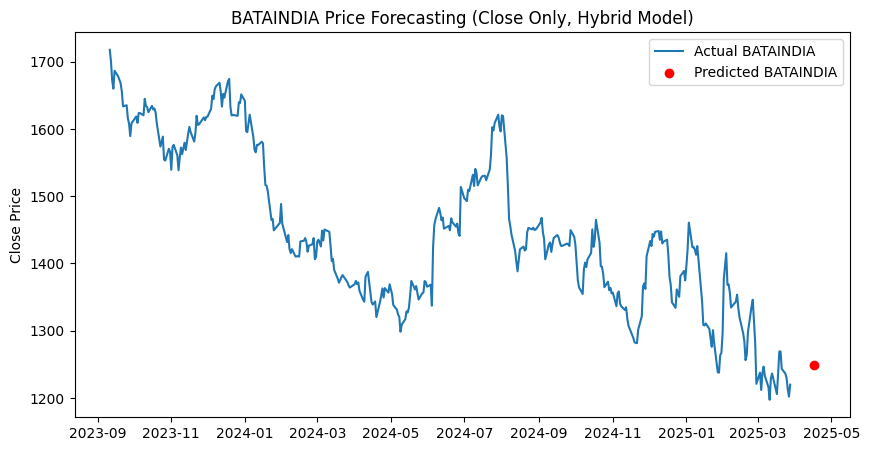

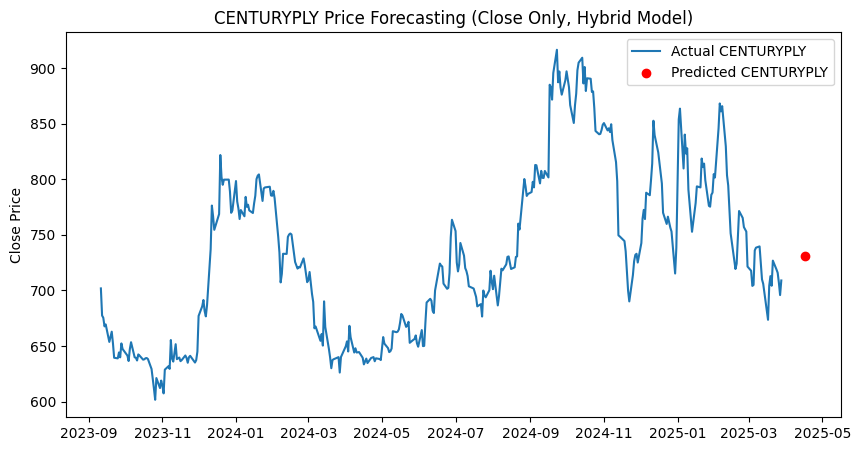

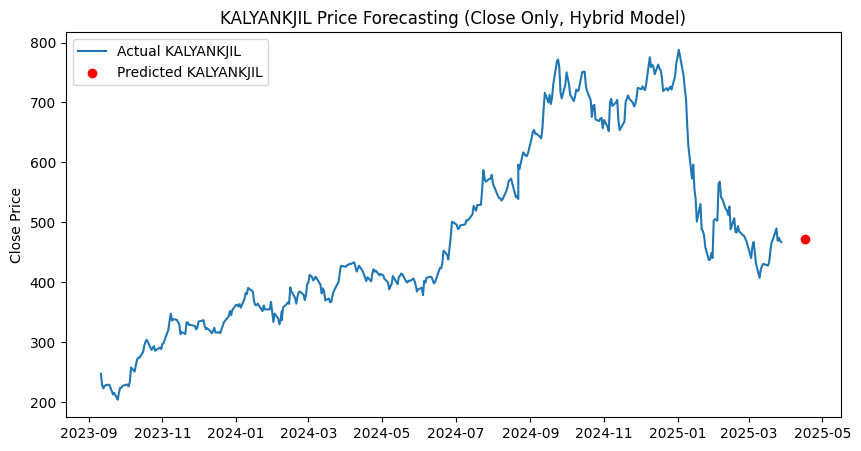

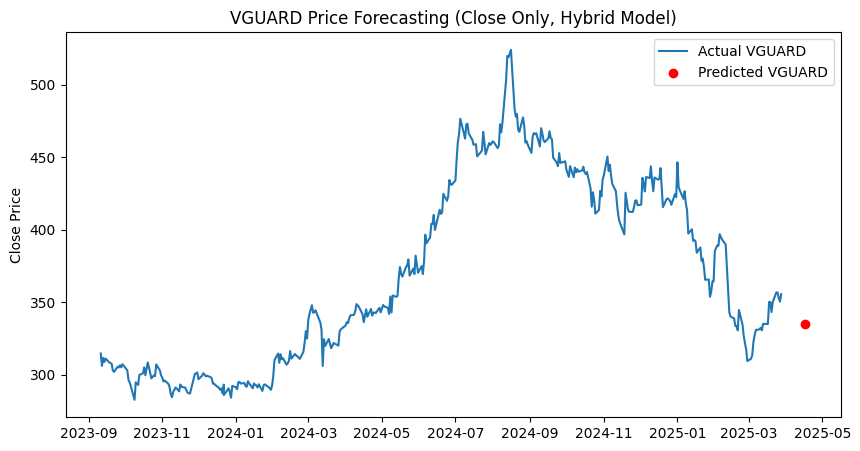

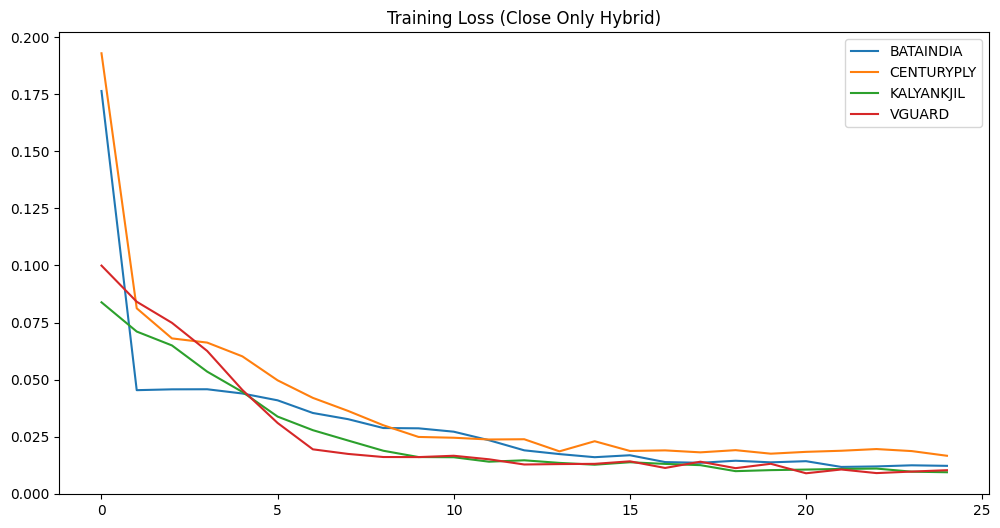

     Stock  Predicted Close      MSE  R-squared     MSLE     MSPE
 BATAINDIA      1248.549511 0.810410   0.189590 0.001440 0.149004
CENTURYPLY       730.654877 0.638907   0.361093 0.002756 0.298688
KALYANKJIL       471.678830 5.195770  -4.195770 0.024312 3.248179
    VGUARD       334.711505 0.617372   0.382628 0.002756 0.282169


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import datetime

# ===============================
# LSTM + Transformer Hybrid Model (Close Price Only)
# ===============================
class HybridModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, lstm_layers=2,
                 d_model=128, nhead=4, trans_layers=2,
                 dim_feedforward=256, dropout=0.1):

        super(HybridModel, self).__init__()

        # LSTM encoder
        self.lstm = nn.LSTM(input_dim, hidden_dim, lstm_layers,
                            batch_first=True,
                            dropout=dropout if lstm_layers > 1 else 0.0)

        # Project LSTM hidden states to transformer d_model
        self.project = nn.Linear(hidden_dim, d_model)
        self.norm = nn.LayerNorm(d_model)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=trans_layers)

        # Final regression head
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        proj = self.project(lstm_out)
        proj = self.norm(proj)

        trans_out = self.transformer_encoder(proj)
        last_token = trans_out[:, -1, :]       # last timestep
        out = self.fc_out(last_token)
        return out


# ===============================
# Dataset using ONLY Close Price
# ===============================
class StockDataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data   # shape: (N, 1)
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        seq = self.data[idx : idx + self.sequence_length]       # (seq_len, 1)
        target = self.data[idx + self.sequence_length][0]       # close price
        return seq, target


# ===============================
# Load CSV and prepare only CLOSE column
# ===============================
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df.rename(columns=lambda x: x.strip(), inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

    df['close'] = df['close'].astype(str).str.replace(',', '').astype(float)

    df = df[['Date', 'close']]
    df.sort_values('Date', inplace=True)
    return df


# ===============================
# Metrics
# ===============================
def mean_squared_log_error(y_true, y_pred):
    return np.mean((np.log1p(y_true) - np.log1p(y_pred))**2)

def mean_squared_percentage_error(y_true, y_pred):
    epsilon = 1e-10
    return np.mean(((y_true - y_pred) / (y_true + epsilon))**2) * 100


# ===============================
# Train hybrid model
# ===============================
def train_model(train_loader, input_dim=1, epochs=25, lr=0.00002, device='cpu'):
    model = HybridModel(input_dim=input_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    epoch_losses = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        count = 0

        for seq, target in train_loader:
            seq = seq.float().to(device)
            target = target.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            count += 1

        epoch_losses.append(epoch_loss / count)

    return model, epoch_losses


# ===============================
# Predict last future price
# ===============================
def predict(model, data, sequence_length=30, device='cpu'):
    seq = torch.tensor(data[-sequence_length:]).float().unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        return model(seq).cpu().item()


# ===============================
# Main Execution
# ===============================
if __name__ == "__main__":
    csv_files = ['BATAINDIA.csv', 'CENTURYPLY.csv', 'KALYANKJIL.csv', 'VGUARD.csv']

    future_date = input("Enter future date (DD-MM-YYYY): ")
    future_date = datetime.datetime.strptime(future_date, "%d-%m-%Y")

    results = []
    all_training_losses = {}
    device = 'cpu'

    for file in csv_files:
        stock_name = os.path.basename(file).replace(".csv", "")
        df = load_and_preprocess_data(file)

        scaler = MinMaxScaler()
        scaled_close = scaler.fit_transform(df[['close']])  # shape (N,1)

        # Split
        train_size = int(len(scaled_close) * 0.8)
        train_data = scaled_close[:train_size]
        test_data = scaled_close[train_size:]

        # Dataset & Dataloader
        train_dataset = StockDataset(train_data)
        test_dataset = StockDataset(test_data)
        train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

        # Train hybrid model (1 feature)
        model, epoch_losses = train_model(train_loader, input_dim=1, device=device)
        all_training_losses[stock_name] = epoch_losses

        predicted_prices = []
        actual_prices = []

        # Prediction on test
        model.eval()
        with torch.no_grad():
            for seq, target in test_loader:
                seq = seq.float().to(device)
                output = model(seq)
                predicted_prices.extend(output.cpu().numpy().flatten())
                actual_prices.extend(target.numpy().flatten())

        # Inverse-scale
        predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1)).flatten()
        actual_prices = scaler.inverse_transform(np.array(actual_prices).reshape(-1, 1)).flatten()

        # Predict final future close
        future_pred_scaled = predict(model, scaled_close, device=device)
        future_prediction = scaler.inverse_transform([[future_pred_scaled]])[0][0]

        actual_price = df['close'].iloc[-1]

        r2 = r2_score(actual_prices, predicted_prices)
        mse = 1 - r2
        mape = mean_absolute_percentage_error(actual_prices, predicted_prices) * 100
        msle = mean_squared_log_error(actual_prices, predicted_prices)
        mspe = mean_squared_percentage_error(actual_prices, predicted_prices)

        results.append([stock_name, future_prediction, mse, r2, msle, mspe])

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(df['Date'], df['close'], label=f"Actual {stock_name}")
        plt.scatter([future_date], [future_prediction], color='red',
                    label=f"Predicted {stock_name}")
        plt.title(f"{stock_name} Price Forecasting (Close Only, Hybrid Model)")
        plt.ylabel("Close Price")
        plt.legend()
        plt.show()

    # Plot all training losses
    plt.figure(figsize=(12, 6))
    for stock, losses in all_training_losses.items():
        plt.plot(losses, label=stock)
    plt.title("Training Loss (Close Only Hybrid)")
    plt.legend()
    plt.show()

    results_df = pd.DataFrame(results, columns=[
        'Stock', 'Predicted Close', 'MSE', 'R-squared', 'MSLE', 'MSPE'
    ])
    print(results_df.to_string(index=False))


ABLATION STUDY

CODE-1: SEQUENCE TO PREDICTION TRANSFORMER WITH Advanced AI Agent Architecture (WITHOUT LTM)

Enter future date (DD-MM-YYYY): 17-04-2025


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([2, 1, 1])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
The attention mask and

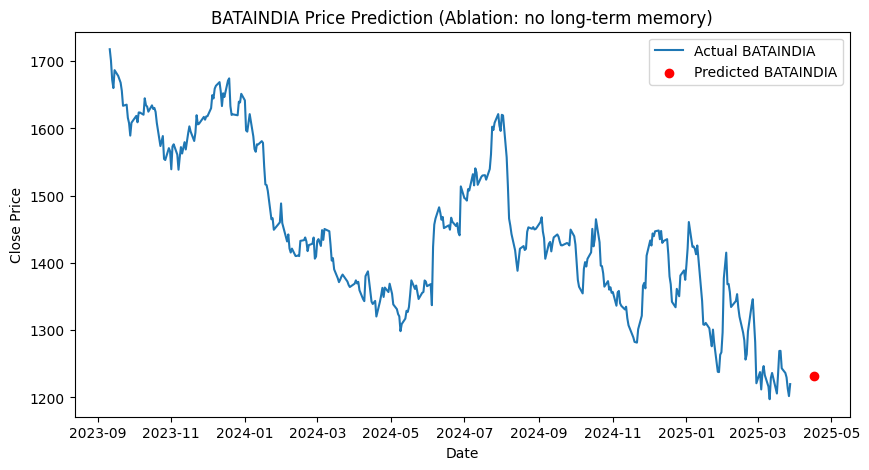

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([2, 1, 1])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
The attention mask and

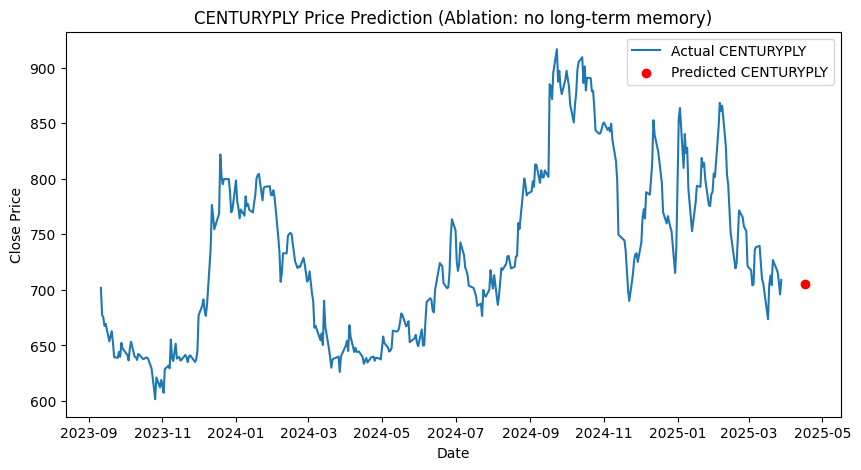

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


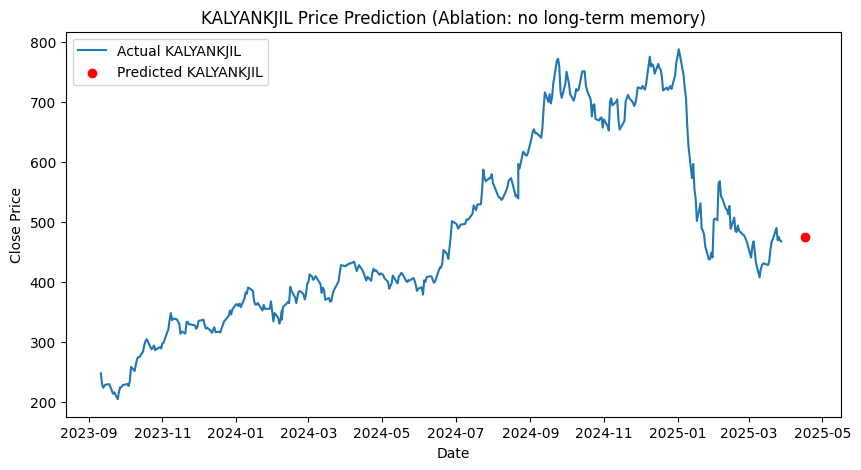

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([3, 1, 1])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
The attention mask and

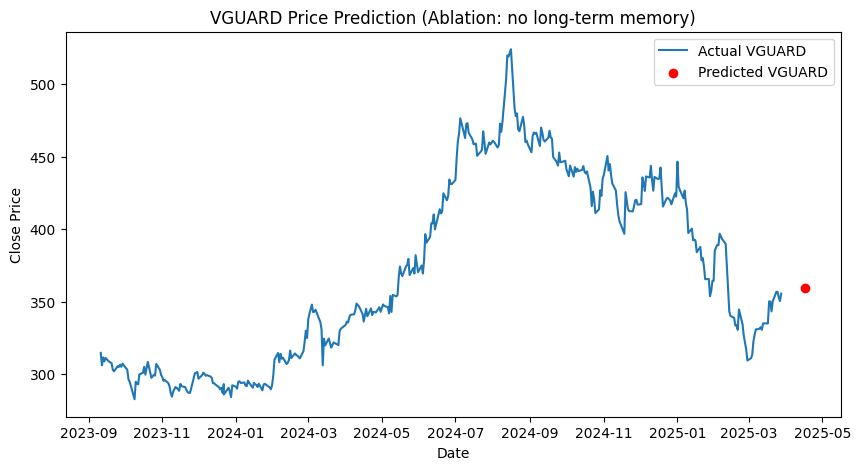

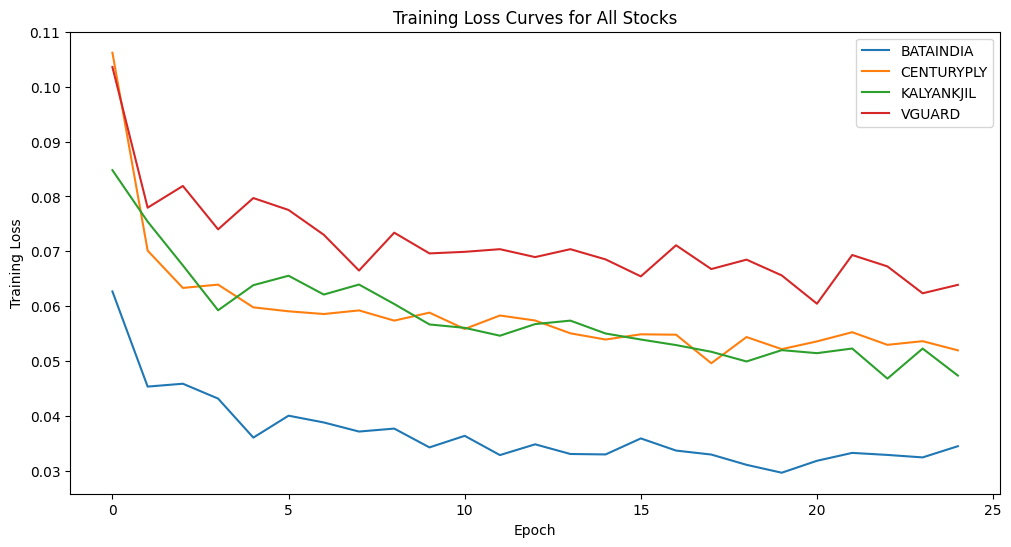

     Stock  Predicted Close      MSE  R-squared     MSLE     MSPE Action    Trend                                                                                                                                                                                                                               Detailed Decision
 BATAINDIA      1232.167901 0.219471   0.780529 0.000387 0.039292    Buy   Upward                The predicted trend for the stock is Upward and the recommended action is to Buy.\n\nThe stock is up by about 10% in the last 24 hours.\n\nThe stock is up by about 10% in the last 24 hours.\n\nThe stock is up by about 10% in
CENTURYPLY       705.373530 0.116344   0.883656 0.000473 0.046551   Sell Downward The predicted trend for the stock is Downward and the recommended action is to Sell.\n\nThe stock is currently trading at $1.00 per share.\n\nThe stock is currently trading at $1.00 per share.\n\nThe stock is currently trading at $1.00 per
KALYANKJIL       473.968353 0.2960

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import datetime
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# ===============================
# Sequence-to-Prediction Transformer Model
# ===============================
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.input_proj(src)
        output = self.transformer_encoder(src)
        output = self.fc_out(output[:, -1, :])
        return output


class StockDataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        return (self.data[idx:idx+self.sequence_length], self.data[idx+self.sequence_length])

def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df.rename(columns=lambda x: x.strip(), inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
    df['close'] = df['close'].astype(str).str.replace(',', '').astype(float)
    df = df[['Date', 'close']]
    df.sort_values('Date', inplace=True)
    return df

def mean_squared_log_error(y_true, y_pred):
    return np.mean((np.log1p(y_true) - np.log1p(y_pred))**2)

def mean_squared_percentage_error(y_true, y_pred):
    epsilon = 1e-10
    return np.mean(((y_true - y_pred) / (y_true + epsilon))**2) * 100

def train_model(train_loader, input_dim, epochs=25, lr=0.00002):
    model = TransformerModel(input_dim=input_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    epoch_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        count = 0
        for seq, target in train_loader:
            optimizer.zero_grad()
            output = model(seq.float())
            loss = criterion(output, target.float().unsqueeze(1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            count += 1
        avg_loss = epoch_loss / count
        epoch_losses.append(avg_loss)
    return model, epoch_losses

# ===============================
# Prediction Function
# ===============================
def predict(model, data, sequence_length=30):
    last_sequence = torch.tensor(data[-sequence_length:]).float().unsqueeze(0)
    predicted_price = model(last_sequence).item()
    return predicted_price

# ===============================
# Advanced AI Agent Architecture (Ablation: NO long-term memory)
# ===============================
class AdvancedAIAgent:
    """
    Ablation variant: Long-term memory removed.
    Keeps:
      - short_term_memory (list)
      - episodic_memory (dict)
    Any requests to store long-term memory are ignored for this ablation study.
    """
    def __init__(self):
        self.short_term_memory = []      # retains recent predictions
        self.episodic_memory = {}        # retains episodic entries
        # long-term memory intentionally removed for ablation

        # LLM components (unchanged)
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        self.llm = GPT2LMHeadModel.from_pretrained("gpt2")

    def update_memory(self, key, value, memory_type="episodic"):
        """
        memory_type: 'short-term' or 'episodic' are supported.
        'long-term' calls will be ignored (removed for ablation).
        """
        if memory_type == "short-term":
            self.short_term_memory.append(value)
        elif memory_type == "episodic":
            self.episodic_memory[key] = value
        elif memory_type == "long-term":
            # Long-term memory has been disabled for this ablation study.
            # Intentionally ignore and do not store.
            return
        else:
            # Unknown memory type: ignore
            return

    def make_decision(self, actual_price, predicted_price):
        # Update episodic & short-term only
        self.update_memory('actual_price', actual_price, memory_type="episodic")
        self.update_memory('predicted_price', predicted_price, memory_type="episodic")
        self.update_memory('last_prediction', predicted_price, memory_type="short-term")

        price_diff = predicted_price - actual_price
        if price_diff > 0:
            action = "Buy"
            trend = "Upward"
        elif price_diff < 0:
            action = "Sell"
            trend = "Downward"
        else:
            action = "Hold"
            trend = "Stable"

        # LLM-Based Detailed Justification (unchanged)
        prompt = (f"The predicted trend for the stock is {trend} and the recommended action is to {action}.")
        inputs = self.tokenizer.encode(prompt, return_tensors="pt")
        outputs = self.llm.generate(inputs, max_length=60, num_return_sequences=1)
        decision_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        return action, trend, decision_text

# ===============================
# Main Execution
# ===============================
if __name__ == "__main__":
    csv_files = ['BATAINDIA.csv','CENTURYPLY.csv','KALYANKJIL.csv','VGUARD.csv']
    future_date = input("Enter future date (DD-MM-YYYY): ")
    future_date = datetime.datetime.strptime(future_date, "%d-%m-%Y")
    results = []

    ai_agent = AdvancedAIAgent()

    all_training_losses = {}

    for file in csv_files:
        stock_name = os.path.basename(file).replace(".csv", "")
        df = load_and_preprocess_data(file)
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df[['close']])

        # Splitting the data into 80% training and 20% testing
        train_size = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:train_size]
        test_data = scaled_data[train_size:]

        train_dataset = StockDataset(train_data)
        test_dataset = StockDataset(test_data)

        train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

        model, epoch_losses = train_model(train_loader, input_dim=1)
        all_training_losses[stock_name] = epoch_losses

        # Predictions
        predicted_prices = []
        actual_prices = []
        model.eval()
        with torch.no_grad():
            for seq, target in test_loader:
                output = model(seq.float())
                predicted_prices.extend(output.numpy().flatten())
                actual_prices.extend(target.numpy().flatten())

        predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1)).flatten()
        actual_prices = scaler.inverse_transform(np.array(actual_prices).reshape(-1, 1)).flatten()

        predicted_price = predict(model, scaled_data)
        predicted_price = scaler.inverse_transform([[predicted_price]])[0][0]

        actual_price = df['close'].iloc[-1]
        r2 = r2_score(actual_prices, predicted_prices)
        mse=1-r2
        mape = mean_absolute_percentage_error(actual_prices, predicted_prices) * 100

        msle = mean_squared_log_error(actual_prices, predicted_prices)
        mspe = mean_squared_percentage_error(actual_prices, predicted_prices)

        # Agent decision (uses only short-term + episodic memory now)
        action, trend, decision_text = ai_agent.make_decision(actual_price, predicted_price)

        results.append([
            stock_name, predicted_price, mse, r2, msle, mspe,
            action, trend, decision_text
        ])

        # Plot for each stock
        plt.figure(figsize=(10, 5))
        plt.plot(df['Date'], df['close'], label=f"Actual {stock_name}")
        plt.scatter([future_date], [predicted_price], color='red', label=f"Predicted {stock_name}")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(f"{stock_name} Price Prediction (Ablation: no long-term memory)")
        plt.legend()
        plt.show()

    # Plot training loss curves for all stocks
    plt.figure(figsize=(12, 6))
    for stock, losses in all_training_losses.items():
        plt.plot(losses, label=stock)
    plt.title("Training Loss Curves for All Stocks")
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.legend()
    plt.show()

    # Results DataFrame
    results_df = pd.DataFrame(results, columns=[
        'Stock', 'Predicted Close', 'MSE', 'R-squared', 'MSLE', 'MSPE',
        'Action', 'Trend', 'Detailed Decision'
    ])
    print(results_df.to_string(index=False))


CODE 2: SEQUENCE TO PREDICTION TRANSFORMER WITH Advanced AI Agent Architecture(BASELINE MODEL - No AI Agent)

Enter future date (DD-MM-YYYY): 17-04-2025


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([2, 1, 1])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


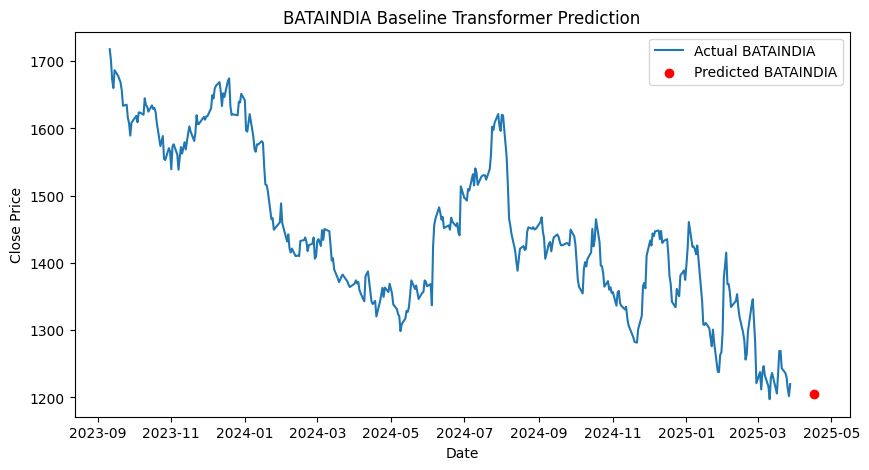

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([2, 1, 1])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


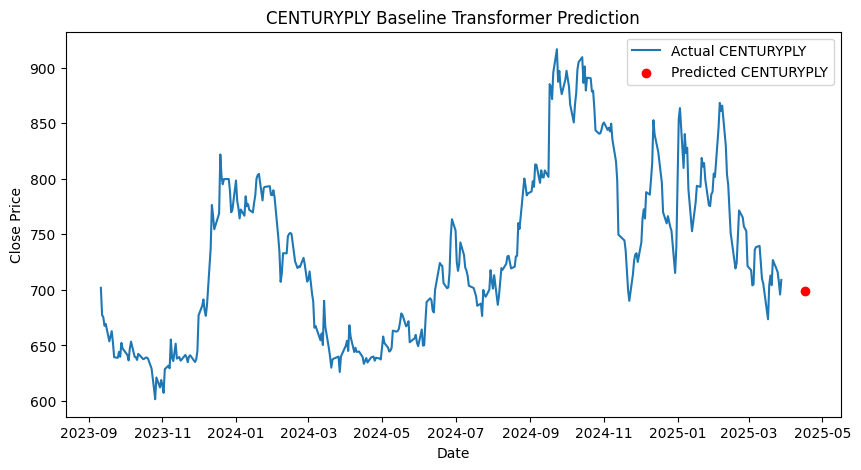

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


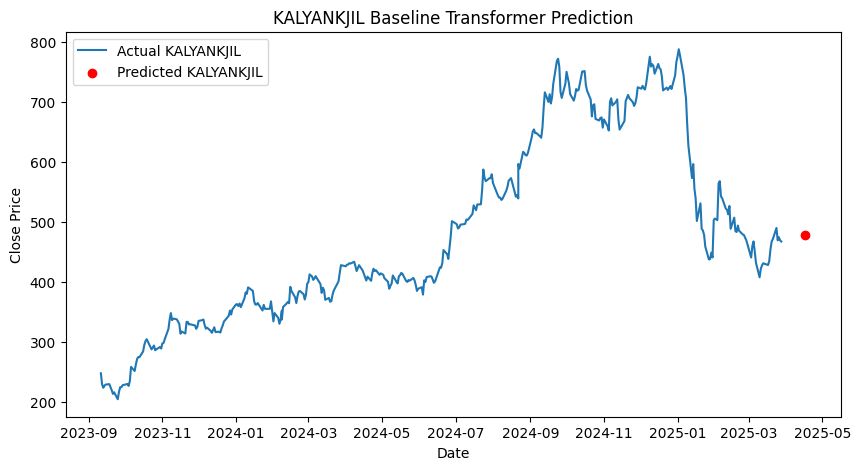

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([3, 1, 1])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


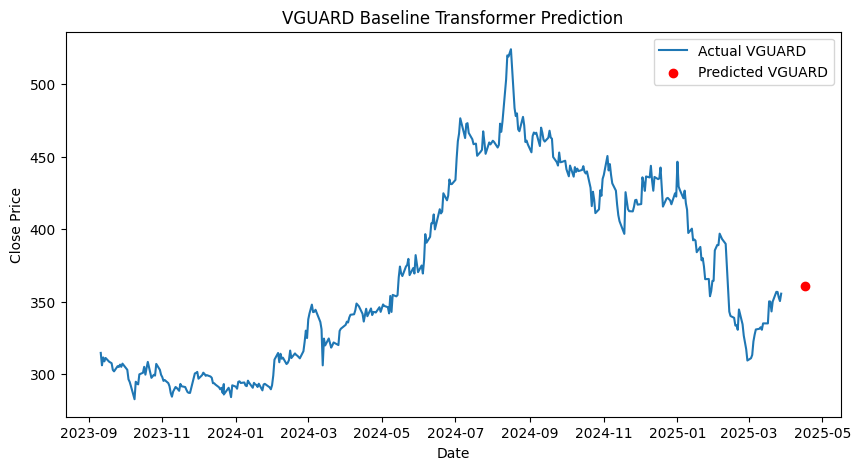

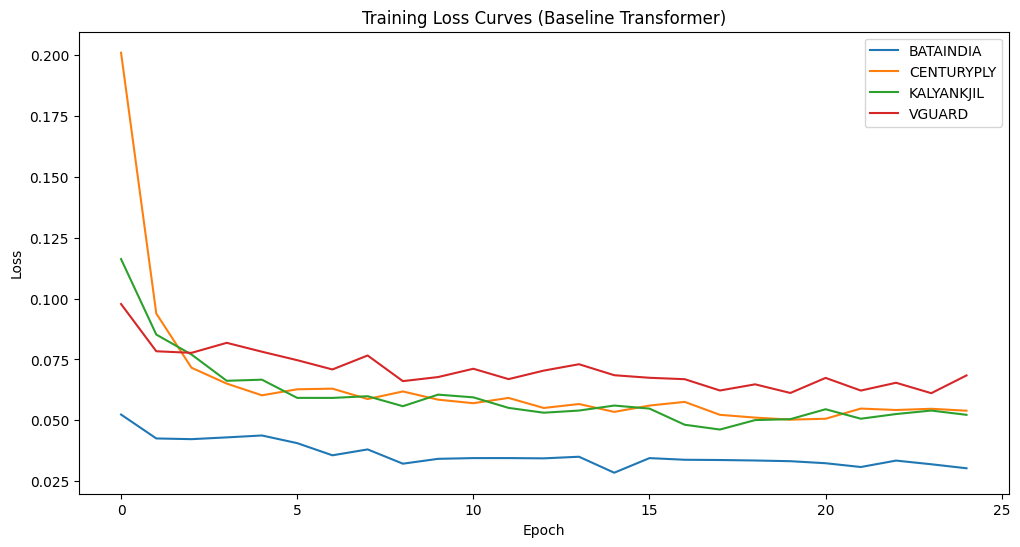

     Stock  Predicted Close      MSE  R-squared     MSLE     MSPE
 BATAINDIA      1204.683660 0.170133   0.829867 0.000296 0.029070
CENTURYPLY       699.268280 0.136945   0.863055 0.000568 0.055329
KALYANKJIL       477.794867 0.329484   0.670516 0.001824 0.188838
    VGUARD       361.177781 0.207729   0.792271 0.000905 0.096009


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import datetime

# ===============================
# Sequence-to-Prediction Transformer Model
# ===============================
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=dim_feedforward,
                                                   dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.input_proj(src)
        output = self.transformer_encoder(src)
        output = self.fc_out(output[:, -1, :])
        return output


# ===============================
# Dataset
# ===============================
class StockDataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        return (self.data[idx:idx+self.sequence_length], self.data[idx+self.sequence_length])


# ===============================
# Load & Preprocess Data
# ===============================
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df.rename(columns=lambda x: x.strip(), inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
    df['close'] = df['close'].astype(str).str.replace(',', '').astype(float)
    df = df[['Date', 'close']]
    df.sort_values('Date', inplace=True)
    return df


# ===============================
# Metrics
# ===============================
def mean_squared_log_error(y_true, y_pred):
    return np.mean((np.log1p(y_true) - np.log1p(y_pred))**2)

def mean_squared_percentage_error(y_true, y_pred):
    eps = 1e-10
    return np.mean(((y_true - y_pred) / (y_true + eps))**2) * 100


# ===============================
# Training Function
# ===============================
def train_model(train_loader, input_dim, epochs=25, lr=0.00002):
    model = TransformerModel(input_dim=input_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    epoch_losses = []

    for epoch in range(epochs):
        total_loss = 0
        count = 0

        for seq, target in train_loader:
            optimizer.zero_grad()
            output = model(seq.float())
            loss = criterion(output, target.float().unsqueeze(1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            count += 1

        epoch_losses.append(total_loss / count)

    return model, epoch_losses


# ===============================
# Prediction Function
# ===============================
def predict(model, data, sequence_length=30):
    last_seq = torch.tensor(data[-sequence_length:]).float().unsqueeze(0)
    pred = model(last_seq).item()
    return pred


# ===============================
# Main Execution (Baseline)
# ===============================
if __name__ == "__main__":
    csv_files = ['BATAINDIA.csv','CENTURYPLY.csv','KALYANKJIL.csv','VGUARD.csv']

    future_date = input("Enter future date (DD-MM-YYYY): ")
    future_date = datetime.datetime.strptime(future_date, "%d-%m-%Y")

    results = []
    all_training_losses = {}

    for file in csv_files:
        stock_name = os.path.basename(file).replace(".csv", "")

        df = load_and_preprocess_data(file)

        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df[['close']])

        # 80/20 split
        train_size = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:train_size]
        test_data = scaled_data[train_size:]

        train_dataset = StockDataset(train_data)
        test_dataset = StockDataset(test_data)

        train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

        model, epoch_losses = train_model(train_loader, input_dim=1)
        all_training_losses[stock_name] = epoch_losses

        # Predictions
        predicted_prices = []
        actual_prices = []

        model.eval()
        with torch.no_grad():
            for seq, target in test_loader:
                out = model(seq.float())
                predicted_prices.extend(out.numpy().flatten())
                actual_prices.extend(target.numpy().flatten())

        # Denormalize
        predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1)).flatten()
        actual_prices = scaler.inverse_transform(np.array(actual_prices).reshape(-1, 1)).flatten()

        # Future single prediction
        future_pred_scaled = predict(model, scaled_data)
        future_pred = scaler.inverse_transform([[future_pred_scaled]])[0][0]

        actual_price = df['close'].iloc[-1]

        # Metrics
        r2 = r2_score(actual_prices, predicted_prices)
        mse = 1 - r2
        mape = mean_absolute_percentage_error(actual_prices, predicted_prices) * 100
        msle = mean_squared_log_error(actual_prices, predicted_prices)
        mspe = mean_squared_percentage_error(actual_prices, predicted_prices)

        results.append([
            stock_name, future_pred, mse, r2, msle, mspe
        ])

        # Plot prediction
        plt.figure(figsize=(10, 5))
        plt.plot(df['Date'], df['close'], label=f"Actual {stock_name}")
        plt.scatter([future_date], [future_pred], color='red', label=f"Predicted {stock_name}")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(f"{stock_name} Baseline Transformer Prediction")
        plt.legend()
        plt.show()

    # Plot training losses
    plt.figure(figsize=(12, 6))
    for stock, losses in all_training_losses.items():
        plt.plot(losses, label=stock)
    plt.title("Training Loss Curves (Baseline Transformer)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Results Table
    results_df = pd.DataFrame(results, columns=[
        'Stock', 'Predicted Close', 'MSE', 'R-squared', 'MSLE', 'MSPE'
    ])

    print(results_df.to_string(index=False))
